In [1]:
import fmpsdk
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import urllib.request
import dash_bootstrap_components as dbc
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from keras.metrics import mean_absolute_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

## Business Problem: Stock prices are a a very important metric because they represent the value of publicly traded companies in  the eyes of society. There is also a strong financial incentive to have a higher stock value for current shareholders because stocks can be liquidated into currency. Stock prices fluctuate based on the supply and demand of stocks associated with a particular company. If stock price can be predicted it could bring these business values:
#### - Increased confidence of return when investing in a company's stock
#### - Increase the confidence of current shareholders regarding stock's direction which can influence their decision to buy/sell your stock
#### - Determine key metrics that drive a stock price up or down
#### - Forecasting stock crashes will lead to the minimization of capital loss
 

## Business Understanding: Predicting stock prices is not an easy task especially regarding the number of variables that go into it. Knowing that a stock price fluctuates based on supply and demand tells me how I will move forward. If I can collect general public sentiment towards a stock, current market trends, and the stock's recent direction, then I am confident that I can predict a stock's price. I will make two types of models for individual stocks, one that predicts the end of day price and one that predicts the price in 4 hours.

# Functions

In [2]:
def build_time_series_df(stock):
    """
    IN: stock : Stock symbol that will be used to build the time series data
    
    OUT: day_df : Dataframe that returns with columns date, close, high,
    change_over_time, volume, and date
    
    """
    #Determine date range, will start with 200 days in the past
    today = datetime.now()
    end_date = today - timedelta(days=200)
    day_stock = fmpsdk.historical_price_full(apikey, stock, from_date = end_date,
                                            to_date = today)
    
    #Construct Dataframe
    day_df = pd.DataFrame(columns = ['Date', 'Close', 'High', 'Change Over Time',
                                    'Volume'])
    dates = []
    closes = []
    highs = []
    change_over_time = []
    changes = []
    volumes = []
    

    #Fill Dataframe
    for day in day_stock['historical']:
        dates.append(day['date'])
        closes.append(day['close'])
        highs.append(day['high'])
        change_over_time.append(day['changeOverTime'])
        volumes.append(day['volume'])
        

    day_df.Date = dates
    day_df.Close = closes
    day_df.High = highs
    day_df['Change Over Time'] = change_over_time
    day_df.Volume = volumes

    day_df.Date = day_df.Date.apply(lambda dat: pd.to_datetime(dat))
    
 
    return day_df


In [3]:
def make_next_hour_pred(stock, series, model):
    cols = ['close_1day', 'close_2day','close_3day', 'high_1day',
              'high_2day', 'high_3day', 'low_1day', 'low_2day',
              'low_3day', 'vol_1day', 'vol_2day', 'vol_3day']
    X = pd.DataFrame(columns = cols)

    last_hour_data = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")[0]

    X.close_1day = pd.Series(last_hour_data['close'])
    X.close_2day = pd.Series(series.Close_1hour[0])
    X.close_3day = pd.Series(series.Close_2hour[0])

    X.high_1day = pd.Series(last_hour_data['high'])
    X.high_2day = pd.Series(series.High_1hour[0])
    X.high_3day = pd.Series(series.High_2hour[0])

    X.low_1day = pd.Series(last_hour_data['low'])
    X.low_2day = pd.Series(series.Low_1hour[0])
    X.low_3day = pd.Series(series.Low_2hour[0])

    X.vol_1day = pd.Series(last_hour_data['volume'])
    X.vol_2day = pd.Series(series.Vol_1hour[0])
    X.vol_3day = pd.Series(series.Vol_2hour[0])

    pred = model.predict(X)
    
    return pred

In [4]:
def make_tomorrow_pred(stock, series, model):
    """
    IN: 
        stock: Stock symbol
        series : Dataframe prediction_df returned from build_general_model_daily_prediction_df
        model: Model retured From build_general_model_daily_prediction_df
    OUT:
        pred : Prediction for next stock day
    
    """
    cols = ['close_1day', 'close_2day','close_3day', 'high_1day',
              'high_2day', 'high_3day', 'cot_1day', 'cot_2day',
              'cot_3day', 'vol_1day', 'vol_2day', 'vol_3day', 'news_sent1day']
    X = pd.DataFrame(columns = cols)
    yesterday_data = fmpsdk.historical_price_full(apikey, stock)['historical'][0]
    
    a = vader_sentiment_analysis(apikey, stock, 20)
    
    X.news_sent1day = pd.Series(np.mean(trim_news_dates(datetime.today().strftime('%Y-%m-%d'), a).CompoundAvg))
    X.news_sent1day.fillna(0, inplace=True)

    X.close_1day = pd.Series(yesterday_data['close'])
    X.close_2day = pd.Series(series.Close_1day[0])
    X.close_3day = pd.Series(series.Close_2day[0])

    X.high_1day = pd.Series(yesterday_data['high'])
    X.high_2day = pd.Series(series.High_1day[0])
    X.high_3day = pd.Series(series.High_2day[0])

    X.cot_1day = pd.Series(yesterday_data['changeOverTime'])
    X.cot_2day = pd.Series(series.Cot_1day[0])
    X.cot_3day = pd.Series(series.Cot_2day[0])

    X.vol_1day = pd.Series(yesterday_data['volume'])
    X.vol_2day = pd.Series(series.Vol_1day[0])
    X.vol_3day = pd.Series(series.Vol_2day[0])

    pred = model.predict(X)
    
    return pred

In [5]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    SOURCE: Claude Fried (https://www.linkedin.com/in/claude-fried/)
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

In [6]:
def vader_sentiment_analysis(apikey, ticker, limit=5000):
    """
    IN: 
    apikey: This should be your personalized api key. You can get one here 
    (https://fmpcloud.io/)

    ticker: This is the stock symbol as or trade name. e.g. TSLA, AAPL, GOOG

    limit: This number references how far back in date you want to go. If you
    want to find the date range please use get_timeframe() on this method's returned df.
    
    OUT: Pandas Dataframe
    """
    #Initialize the sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    #Collect the data from the fmpsdk api
    news = fmpsdk.stock_news(apikey=apikey, tickers=ticker, limit=limit)
    #Construct the dataframe with predtermined columns
    df = pd.DataFrame(columns=['Date', 'Title', 'Text', 'CompoundScoreTitle',
                          'PositiveScoreTitle', 'NegativeScoreTitle', 
                          'CompoundScoreText', 'NeutralScoreTitle',
                           'NeutralScoreText', 'textLeans', 'titleLeans',
                          'PositiveScoreText', 'NegativeScoreText',
                          'CompoundAvg', 'Symbol'])
    
    dates = []
    titles = []
    text_ = []
    symbols = []


    #Loops through the news variable which contains the data from the api. For 
    #loop the lists dates, titles, & text_ get appended so that the df above can
    #then have three columns with data
    for article in news:
        dates.append(article['publishedDate'])
        titles.append(article['title'])
        text_.append(article['text']) 
        symbols.append(article['symbol'])
    df.Date = pd.to_datetime(dates)
    df.Title = titles
    df.Text = text_
    df.Symbol = symbols
    
    #Removes None values from text that can appear
    df.Text = df.Text.apply(lambda txt: txt if txt != None else('Blank'))
    #Scores the title of the articles using compound score
    df.CompoundScoreTitle = df.Title.apply(lambda title:
    sid.polarity_scores(title)['compound'])
    #Scores the title of the articles using positive score
    df.PositiveScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['pos'])
    #Scores the title of the articles using negative score
    df.NegativeScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neg'])
    #Scores the title of the articles using neutral score
    df.NeutralScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neu'])
    #Scores the text of the articles using compound score
    df.CompoundScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['compound'])
    #Scores the text of the articles using positive score
    df.PositiveScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['pos'])
    #Scores the text of the articles using negative score
    df.NegativeScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neg'])
    #Scores the text of the articles using neutral score
    df.NeutralScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neu'])
    
    #I will now add two columns to the dataframe that will tell me which way the
    #sentiment analyzer is leaning in regards to tile and text. I will be using
    #the comound score here because it is the best representation of positve/neutral
    #& negative scores.

    #If the title comound score is less than 0 I determine that the title leans negative
    #if the comound score is greater than 0 I dettermine that the title leans
    #positive. Otherwise neutral.
    df.titleLeans = df.CompoundScoreTitle.apply(lambda score:
                    'Negative' if score < 0 
                     else('Positive' if score > 0
                          else('Neutral')))
                        
    df.textLeans = df.CompoundScoreText.apply(lambda score:
                        'Negative' if score < 0 
                         else('Positive' if score > 0
                              else('Neutral')))
    #Now I will add the day of the week
    #Days of the week are numberd 0-6 where 0 is Monday
    df['weekday'] = df.Date.apply(lambda date:
                                  date.weekday())
    #The time corresponding with the date will also need to in it's own column
    #for later processing
    df['time'] = df.Date.apply(lambda date:
                               date.time())
    #Finally I add the average of the comound scores for the title and text of a 
    #given article
    df.CompoundAvg = (df.CompoundScoreTitle + df.CompoundScoreText)/2
    
    return df

In [7]:
def trim_news_dates(stock_prediction_day, df):
  """
  This function will trim a provided dataframe to only contain dates relevant to
  the stock_prediction_day.

  IN: 
   - stock_prediction_day: This is the date that one would like to predict a 
   stocks gain/loss should be a string in the form 'YYYY-MM-DD'
   - df: This is the data frame that will be trimmed and returned only contaning
   dates relavant to the prediction
  """

  #Set start_cutoff to one day before stock_prediction_day at 4:00 PM as
  #a pandas datetime object
  end_cutoff = pd.to_datetime(stock_prediction_day + ' 16:00:00')
  start_cutoff = end_cutoff - timedelta(days=1)
  
  return df.loc[(df.Date >= start_cutoff) &
       (df.Date <= end_cutoff)]

def determine_date_range(df):
  """
  IN: pandas data frame that you would like to know the date range of
  OUT: Date range in pandas.datetime format
  """
  end_date = df.Date[0]
  start_date = df.Date[df.shape[0]-1]
  return (start_date, end_date)

In [8]:
def build_xgboost_hourly_df(symbol):
    
    prediction_df = pd.DataFrame(columns = ['Close_1hour',
                                            'Close_2hour',
                                            'Close_3hour',
                                            #'Close_4day',
                                            #'Close_5day',
                                            'High_1hour',
                                            'High_2hour',
                                            'High_3hour',
                                            #'High_4day',
                                           #'High_5day',
                                            'Low_1hour',
                                            'Low_2hour',
                                           'Low_3hour',
                                           # 'Cot_4day',
                                            #'Cot_5day',
                                           'Vol_1hour',
                                            'Vol_2hour',
                                            'Vol_3hour',
                                            #'Vol_4day',
                                            #'Vol_5day',
                                            'value',
                                            'Time'
                                       ])
    stock_df = build_time_series_hourly_df(symbol)
    prediction_df.value = stock_df.Close[0:(stock_df.shape[0])-5]
    prediction_df.Time = stock_df.Time
    day_1_close = []
    day_2_close = []
    day_3_close = []
    day_4_close = []
    day_5_close = []

    High_1day = []
    High_2day = []
    High_3day = []
    High_4day = []
    High_5day = []

    Low_1day = []
    Low_2day = []
    Low_3day = []
    Low_4day= []
    Low_5day= []

    Vol_1day = []
    Vol_2day = []
    Vol_3day = []
    Vol_4day = []
    Vol_5day = []
    for i in range(len(prediction_df.value)):

        day_1_close.append(stock_df.Close[i+1])
        day_2_close.append(stock_df.Close[i+2])
        day_3_close.append(stock_df.Close[i+3])
#         day_4_close.append(stock_df.Close[i+4])
#         day_5_close.append(stock_df.Close[i+5])

        High_1day.append(stock_df.High[i+1])
        High_2day.append(stock_df.High[i+2])
        High_3day.append(stock_df.High[i+3])
#         High_4day.append(stock_df.High[i+4])
#         High_5day.append(stock_df.High[i+5])

        Low_1day.append(stock_df['Low'][i+1])
        Low_2day.append(stock_df['Low'][i+2])
        Low_3day.append(stock_df['Low'][i+3])
#         Cot_4day.append(stock_df['Change Over Time'][i+4])
#         Cot_5day.append(stock_df['Change Over Time'][i+5])

        Vol_1day.append(stock_df.Volume[i+1])
        Vol_2day.append(stock_df.Volume[i+2])
        Vol_3day.append(stock_df.Volume[i+3])
#         Vol_4day.append(stock_df.Volume[i+4])
#         Vol_5day.append(stock_df.Volume[i+5])

    prediction_df.Close_1hour = day_1_close
    prediction_df.Close_2hour = day_2_close
    prediction_df.Close_3hour = day_3_close
#     prediction_df.Close_4day = day_4_close
#     prediction_df.Close_5day = day_5_close

    prediction_df.High_1hour = High_1day
    prediction_df.High_2hour = High_2day
    prediction_df.High_3hour = High_3day
#     prediction_df.High_4day= High_4day
#     prediction_df.High_5day= High_5day

    prediction_df.Low_1hour = Low_1day
    prediction_df.Low_2hour = Low_2day
    prediction_df.Low_3hour = Low_3day
#     prediction_df.Cot_4day = Cot_4day
#     prediction_df.Cot_5day = Cot_5day

    prediction_df.Vol_1hour = Vol_1day
    prediction_df.Vol_2hour = Vol_2day
    prediction_df.Vol_3hour = Vol_3day
#     prediction_df.Vol_4day = Vol_4day
#     prediction_df.Vol_5day = Vol_5day

        
    return prediction_df

In [9]:
def build_time_series_hourly_df(symbol):

    hourly_stock = fmpsdk.historical_chart(apikey, symbol, "1hour")
    
    hourly_df = pd.DataFrame(columns = ['Time', 'Close', 'High', 'Volume', 'Low'])
    opens = []
    times = []
    closes = []
    highs = []
    volumes = []
    lows = []
    for hour in hourly_stock:
        times.append(hour['date'])
        opens.append(hour['open'])
        closes.append(hour['close'])
        highs.append(hour['high'])
        volumes.append(hour['volume'])
        lows.append(hour['low'])

    hourly_df.Time = times
    hourly_df.Close = closes
    hourly_df.High = highs
    hourly_df.Volume = volumes
    hourly_df.Low = lows

 
    return hourly_df


In [10]:
def build_general_model_daily_prediction_df(stock):
    """
    IN: stock : Stock Symbol
    
    OUT: 
        xgboost_prediction_df: Dataframe containing train, test, and prediction 
    results
        xg: Model used for prediction
        prediction_df : Dataframe used to train and test model
        mae : Mean Absolue Error of model from test results
          
    """
    prediction_df = build_xgboost_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                            prediction_df[int(len(prediction_df)*.1):]
    
    X_test = test_data.drop(columns = ['Date', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Date', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Date = prediction_df.Date



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
    count = 0
    i = 0
    for date in xgboost_prediction_df.Date:
        if str(date)[0] == 'N':
            xgboost_prediction_df.Date[count] = pred_dates[i]
            i += 1
        count += 1
        
    
    return xgboost_prediction_df, xg, prediction_df, mae

In [11]:
def build_general_model_hourly_prediction_df(stock):
    prediction_df = build_xgboost_hourly_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.05)], \
                            prediction_df[int(len(prediction_df)*.05):]
    
    X_test = test_data.drop(columns = ['Time', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Time', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Time = prediction_df.Time



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
    count = 0
    i = 0
    for date in xgboost_prediction_df.Time:
        if date is np.nan:
            xgboost_prediction_df.Time[count] = pred_dates[i]
            i += 1
        count += 1
        
    #return pred_dates, xgboost_prediction_df
    return xgboost_prediction_df, xg, prediction_df, mae

In [12]:
def build_xgboost_df(symbol):
    """
    IN: symbol : The desired stock symbol to build the xgboost dataframe
    
    OUT: prediction_df : Dataframe that has past 3 day data for a given day with an associated value
    column that is the target variable.
    
    """
    
    prediction_df = pd.DataFrame(columns = ['Close_1day',
                                            'Close_2day',
                                            'Close_3day',
                                            #'Close_4day',
                                            #'Close_5day',
                                            'High_1day',
                                            'High_2day',
                                            'High_3day',
                                            #'High_4day',
                                           #'High_5day',
                                            'Cot_1day',
                                            'Cot_2day',
                                           'Cot_3day',
                                           # 'Cot_4day',
                                            #'Cot_5day',
                                           'Vol_1day',
                                            'Vol_2day',
                                            'Vol_3day',
                                            #'Vol_4day',
                                            #'Vol_5day',
                                            'value',
                                            'Date'
                                       ])
    stock_df = build_time_series_df(symbol)
    prediction_df.value = stock_df.Close[0:(stock_df.shape[0])-5]
    
    prediction_df.Date = stock_df.Date
    
    day_1_close = []
    day_2_close = []
    day_3_close = []
    day_4_close = []
    day_5_close = []

    High_1day = []
    High_2day = []
    High_3day = []
    High_4day = []
    High_5day = []

    Cot_1day = []
    Cot_2day = []
    Cot_3day = []
    Cot_4day= []
    Cot_5day= []

    Vol_1day = []
    Vol_2day = []
    Vol_3day = []
    Vol_4day = []
    Vol_5day = []
    for i in range(len(prediction_df.value)):

        day_1_close.append(stock_df.Close[i+1])
        day_2_close.append(stock_df.Close[i+2])
        day_3_close.append(stock_df.Close[i+3])
#         day_4_close.append(stock_df.Close[i+4])
#         day_5_close.append(stock_df.Close[i+5])

        High_1day.append(stock_df.High[i+1])
        High_2day.append(stock_df.High[i+2])
        High_3day.append(stock_df.High[i+3])
#         High_4day.append(stock_df.High[i+4])
#         High_5day.append(stock_df.High[i+5])

        Cot_1day.append(stock_df['Change Over Time'][i+1])
        Cot_2day.append(stock_df['Change Over Time'][i+2])
        Cot_3day.append(stock_df['Change Over Time'][i+3])
#         Cot_4day.append(stock_df['Change Over Time'][i+4])
#         Cot_5day.append(stock_df['Change Over Time'][i+5])

        Vol_1day.append(stock_df.Volume[i+1])
        Vol_2day.append(stock_df.Volume[i+2])
        Vol_3day.append(stock_df.Volume[i+3])
#         Vol_4day.append(stock_df.Volume[i+4])
#         Vol_5day.append(stock_df.Volume[i+5])

    prediction_df.Close_1day = day_1_close
    prediction_df.Close_2day = day_2_close
    prediction_df.Close_3day = day_3_close
#     prediction_df.Close_4day = day_4_close
#     prediction_df.Close_5day = day_5_close

    prediction_df.High_1day = High_1day
    prediction_df.High_2day= High_2day
    prediction_df.High_3day= High_3day
#     prediction_df.High_4day= High_4day
#     prediction_df.High_5day= High_5day

    prediction_df.Cot_1day = Cot_1day
    prediction_df.Cot_2day = Cot_2day
    prediction_df.Cot_3day = Cot_3day
#     prediction_df.Cot_4day = Cot_4day
#     prediction_df.Cot_5day = Cot_5day

    prediction_df.Vol_1day = Vol_1day
    prediction_df.Vol_2day = Vol_2day
    prediction_df.Vol_3day = Vol_3day
#     prediction_df.Vol_4day = Vol_4day
#     prediction_df.Vol_5day = Vol_5day

    prediction_df['News_Sentiment_1day'] = None
    news_df = vader_sentiment_analysis(apikey, symbol)
    prediction_df.News_Sentiment_1day = prediction_df.Date.apply(
        lambda dat: np.mean(trim_news_dates(str(dat), news_df).CompoundAvg))

    
    
    return prediction_df

In [13]:
def build_general_model_hourly_prediction_df(stock):
    prediction_df = build_xgboost_hourly_df(stock)

    test_data, train_data = prediction_df[0:int(len(prediction_df)*.025)], \
                            prediction_df[int(len(prediction_df)*.025):]
    
    X_test = test_data.drop(columns = ['Time', 'value'])

    y_train = train_data.value
    X_train = train_data.drop(columns = ['Time', 'value'])
    y_test = test_data.value

    xg = GradientBoostingRegressor()
    xg.fit(X_train, y_train)
    y_pred = pd.Series(xg.predict(X_test))
    mae = np.sqrt(mean_squared_error(y_test, y_pred))
    
    xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
    combined_list = pd.concat([y_test, y_train, y_pred])
    combined_list.reset_index(drop = True, inplace = True)

    xgboost_prediction_df.value = combined_list
    xgboost_prediction_df.Time = prediction_df.Time



    test_cutoff = len(y_test)
    pred_cutoff = len(y_test) + len(y_train)
    counter = 0
    for i in range(len(combined_list)):
        if (counter > test_cutoff)&(counter < pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'train'
        elif (counter <= test_cutoff):
            xgboost_prediction_df.data_category[i] = 'test'
        elif (counter >= pred_cutoff):
            xgboost_prediction_df.data_category[i] = 'pred'
        counter += 1
            
    pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
    count = 0
    i = 0
    for date in xgboost_prediction_df.Time:
        if date is np.nan:
            xgboost_prediction_df.Time[count] = pred_dates[i]
            i += 1
        count += 1
        
    #return pred_dates, xgboost_prediction_df
    return xgboost_prediction_df, xg, prediction_df, mae

# Obtain

#### Data Understanding
 - The data comes from the FMP Cloud API https://fmpcloud.io/. This API contains accurate live stock information. It is important when working with stock time series data that the data comes from a live reputable source.
 - I will be using the following data for modeling high price, low price, close price, volume,and change over time.
 - For the live dashboard I will be using financial statements, recent news, insider trades, stock price history, current price, earning per share, and analyst ratings.
 - The data used in modeling is important because the models will be able to predict the upcoming price simply by following the trend outlined by the numerical time series data. The data for the dashboard is more qualitative and is meant for human analysis. For example, the recent news data is still best understood by reading it.
 - The limitations of the data are that there is not whole market data available through FMP cloud. This will limit the model because it will not have any information regarding global market trends.
 
#### Data Preparation
- I will be training models on time series data which means I will need to make windows into the past. Models predicting daily will be built with different data than hourly models. 
- Making time series model is appropriate because if we can predict the next hour/day close price then business value if gained. E.g. If the investing party knows the price will be higher tomorrow the party can make a purchase at the time of evaluation and make a short term profit by selling the next day. This is only possible if models maintain high confidence.
- The daily models will also contain news sentiment scores, this should explain some of the noise to the model. i.e. The noise that is introduced from human sentiment regarding a particular stock.

#### The Plan:
- Build a general ARIMA model that will predict the next day close of any stock
- To start I will build the model based on a single stock
- Final product will be a function that will have one parameter, stock symbol, that creates and ARIMA model predicting the stock close.
- I will also create a visualization that follows the stock price and also shows the model prediction.
- Ultimately, a user interacting with the dashboard will be able to select a graph that shows this prediction vs actual line plot and will also print out the predicted close price.

#### Alternative Plan:
- Build an XGBOOST model that will predict next day stock_close

In [14]:
day_stock = fmpsdk.historical_price_full(apikey, 'AMZN')

In [15]:
len(day_stock)

2

In [16]:
type(day_stock)

dict

In [17]:
day_stock.keys()

dict_keys(['symbol', 'historical'])

In [18]:
len(day_stock['historical'])

1258

In [19]:
(day_stock['historical'])[0]

{'date': '2021-12-02',
 'open': 3460.0,
 'high': 3492.7,
 'low': 3424.6399,
 'close': 3437.3601,
 'adjClose': 3437.3601,
 'volume': 3236327.0,
 'unadjustedVolume': 3236327.0,
 'change': -22.6399,
 'changePercent': -0.654,
 'vwap': 3451.56667,
 'label': 'December 02, 21',
 'changeOverTime': -0.00654}

#### The API allows for the amount of data to be collected to be changed. Considering that it called 1258 days for the AMZN ticker above, I will leave this parameter empty. Next I need to get the data into matrix form.

In [20]:
amzn_df = build_time_series_df('AMZN')

#### I will now take a quick look at autocorrelation plot for the data.

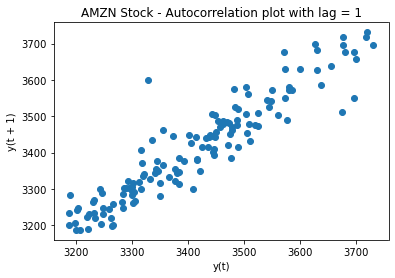

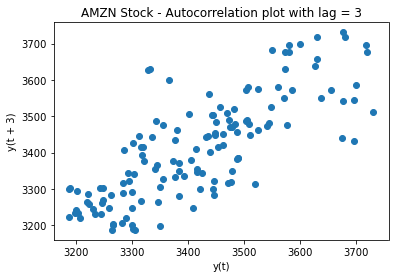

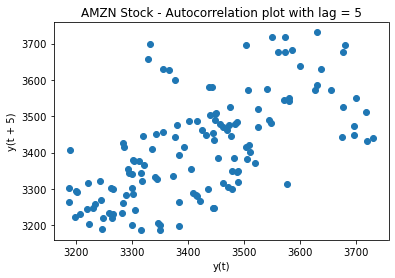

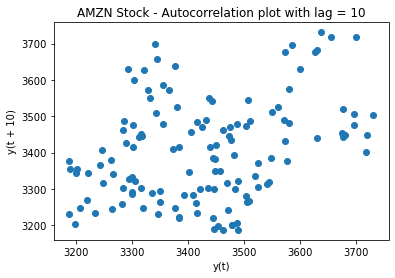

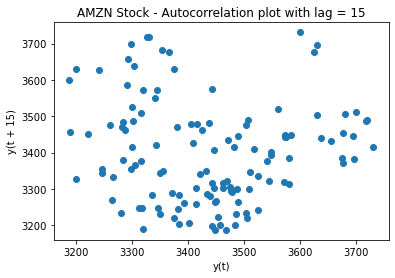

In [21]:
lags = [1, 3, 5, 10, 15]


for lag_ in lags:
    plt.figure()
    lag_plot(amzn_df['Close'], lag=lag_)
    plt.title('AMZN Stock - Autocorrelation plot with lag = '+str(lag_))
    plt.show()

#### Based on the charts above we can concluse that an ARIMA model is correct for our use but lag should remain under 5. I will now look at stationarity using the ADF test. If the p-value > .05 I need to find the order of differencing.

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(amzn_df.Close)
print(f"ADF Stats: {result[0]} ")
print(f"p-value: {result[1]} ")

ADF Stats: -2.4157433710887375 
p-value: 0.13734217139082194 


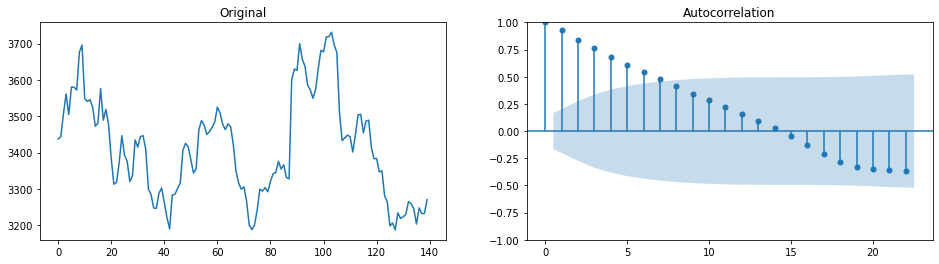

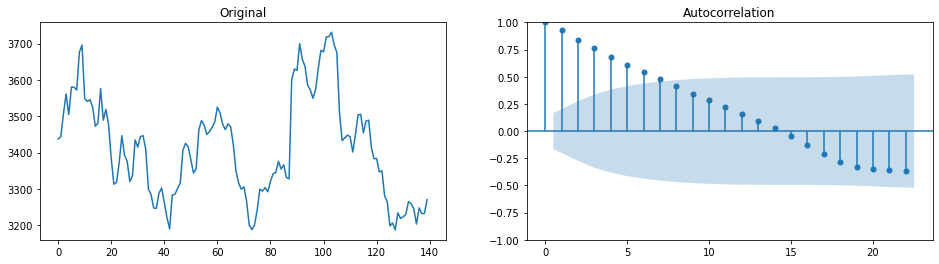

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(amzn_df.Close)
ax1.set_title('Original')
plot_acf(amzn_df.Close, ax=ax2)

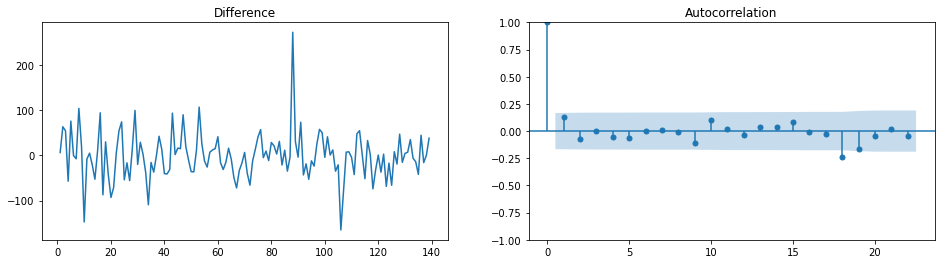

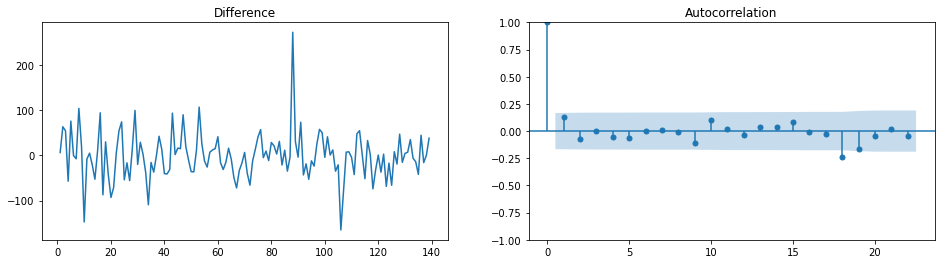

In [24]:
diff = amzn_df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference')
plot_acf(diff, ax=ax2)

# Train Test Split

In [25]:
amzn_df.head()

Date      Close       High  Change Over Time     Volume
0 2021-12-02  3437.3601  3492.7000          -0.00654  3236327.0
1 2021-12-01  3443.7200  3559.8799          -0.02857  3746074.0
2 2021-11-30  3507.0701  3585.7700          -0.01584  4001205.0
3 2021-11-29  3561.5701  3596.0000           0.00393  3179297.0
4 2021-11-26  3504.5601  3633.5000          -0.02708  2991527.0

In [26]:
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values


# Model

In [27]:
train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))



Testing Mean Absolute Error is 41.917593695670206


# Neural Network
- Goal: Make a model that can be saved and make predictions provided with testing data

## First, I will prepare the data. I will be using hourly data to increase predictability. Also, this model will be trained on many stocks.
- First I will construct a working product with a rudimentary list of stocks i.e. less than 20
- Once I've confirmed model validity I will increase the list substantially and investigate performance increases

In [28]:
train_symbols = ['MSFT', 'AMZN', 'AAPL', 'GE', 'F', 'TSLA', 'PG', 'JNJ',
                'ZM', 'GOOG', 'MGM', 'FB', 'AAL', 'PFE', 'CCL',
                'BAC']

In [29]:
final_train_df = build_general_model_hourly_prediction_df('BNTX')[2]

In [30]:
for sym in train_symbols:
    df = build_general_model_hourly_prediction_df(sym)[2]
    print(sym)
    print(df.shape[0])
    final_train_df = final_train_df.append(df)

MSFT
360
AMZN
434
AAPL
273
GE
435
F
295
TSLA
287
PG
435
JNJ
434
ZM
434
GOOG
433
MGM
435
FB
345
AAL
322
PFE
358
CCL
313
BAC
377


In [31]:
final_train_df.shape

(6397, 14)

In [32]:
final_train_df.reset_index(drop = True, inplace = True)

In [33]:
final_train_df

Close_1hour  Close_2hour  Close_3hour  High_1hour  High_2hour  \
0        333.5000     330.7381     325.8605    334.7800    331.7900   
1        330.7381     325.8605     326.3400    331.7900    328.6200   
2        325.8605     326.3400     325.4750    328.6200    330.9700   
3        326.3400     325.4750     329.8200    330.9700    329.9565   
4        325.4750     329.8200     330.6499    329.9565    335.0000   
...           ...          ...          ...         ...         ...   
6392      40.3400      40.3200      40.3250     40.3850     40.4199   
6393      40.3200      40.3250      40.1600     40.4199     40.4800   
6394      40.3250      40.1600      40.4500     40.4800     40.4150   
6395      40.1600      40.4500      40.4500     40.4150     40.6800   
6396      40.4500      40.4500      40.6800     40.6800     40.7750   

      High_3hour  Low_1hour  Low_2hour  Low_3hour  Vol_1hour  Vol_2hour  \
0       328.6200    330.300    325.635     322.66     588902     344278   
1       330.9700    325.635    322.660     323.72     344278     254964   
2       329.9565    322.660    323.720     319.85     254964     390024   
3       335.0000    323.720    319.850     323.23     390024     533987   
4       334.9000    319.850    323.230     328.02     533987     827985   
...          ...        ...        ...        ...        ...        ...   
6392     40.4800     40.260     40.255      40.13    3464948    4161560   
6393     40.4150     40.255     40.130      40.08    4161560    4788199   
6394     40.6800     40.130     40.080      40.40    4788199    7124260   
6395     40.7750     40.080     40.400      40.43    7124260    2690173   
6396     40.7100     40.400     40.430      40.55    2690173    7968942   

      Vol_3hour     value                 Time  
0        254964  336.7000  2021-12-02 16:00:00  
1        390024  333.5000  2021-12-02 15:00:00  
2        533987  330.7381  2021-12-02 14:00:00  
3        827985  325.8605  2021-12-02 13:00:00  
4          8250  326.3400  2021-12-02 12:00:00  
...         ...       ...                  ...  
6392    4788199   40.4869  2021-09-17 14:00:00  
6393    7124260   40.3400  2021-09-17 13:00:00  
6394    2690173   40.3200  2021-09-17 12:00:00  
6395    7968942   40.3250  2021-09-17 11:00:00  
6396    3372583   40.1600  2021-09-17 10:00:00  

[6397 rows x 14 columns]

#### - Now, I will scale the data and add it to the model
#### - I will split the data into only a train and validation set because I can extract an unseen test set right before model validation. The validation split will help train the neural network.

### Train Test Split

In [34]:
X = final_train_df.drop(columns = ['Time', 'value'])
y = final_train_df['value']

#y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

### Scale

In [35]:
sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# y_train_scaled = special_sc.fit_transform(y_train)
# y_test_scaled = special_sc.transform(y_test)

In [36]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



### Model Construction

In [37]:
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.metrics import mean_absolute_error

In [38]:
#pip install -U numpy==1.19.2

In [39]:
model = Sequential()

model.add(Dense(units = 50, input_shape = (X_train_scaled.shape[1], 1)))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'relu'))


model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting the RNN to the Training set
history = model.fit(X_train_scaled, y_train, epochs = 850, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=50, restore_best_weights=True)])





Epoch 1/850
140/140 [==============================] - 0s 2ms/step - loss: 1434540.5000 - mean_absolute_error: 589.3287 - val_loss: 1318405.3750 - val_mean_absolute_error: 567.1417
Epoch 2/850
140/140 [==============================] - 0s 2ms/step - loss: 1220434.6250 - mean_absolute_error: 531.6528 - val_loss: 883247.7500 - val_mean_absolute_error: 449.4141
Epoch 3/850
140/140 [==============================] - 0s 2ms/step - loss: 707172.8125 - mean_absolute_error: 420.2587 - val_loss: 536622.7500 - val_mean_absolute_error: 391.5301
Epoch 4/850
140/140 [==============================] - 0s 1ms/step - loss: 582968.7500 - mean_absolute_error: 406.1846 - val_loss: 524143.1250 - val_mean_absolute_error: 382.7007
Epoch 5/850
140/140 [==============================] - 0s 1ms/step - loss: 580392.3750 - mean_absolute_error: 398.3976 - val_loss: 523234.4375 - val_mean_absolute_error: 377.5150
Epoch 6/850
140/140 [==============================] - 0s 1ms/step - loss: 579843.6875 - mean_absolute

140/140 [==============================] - 0s 3ms/step - loss: 580363.5625 - mean_absolute_error: 392.7411 - val_loss: 522722.4375 - val_mean_absolute_error: 372.7395
Epoch 47/850
140/140 [==============================] - 1s 4ms/step - loss: 581141.7500 - mean_absolute_error: 391.8760 - val_loss: 522856.3750 - val_mean_absolute_error: 371.0291
Epoch 48/850
140/140 [==============================] - 0s 3ms/step - loss: 580363.1250 - mean_absolute_error: 392.4878 - val_loss: 523129.3438 - val_mean_absolute_error: 371.2856
Epoch 49/850
140/140 [==============================] - 0s 2ms/step - loss: 581796.4375 - mean_absolute_error: 391.4428 - val_loss: 523237.0625 - val_mean_absolute_error: 371.6441
Epoch 50/850
140/140 [==============================] - 0s 1ms/step - loss: 581472.1250 - mean_absolute_error: 392.7134 - val_loss: 523520.5000 - val_mean_absolute_error: 372.9046
Epoch 51/850
140/140 [==============================] - 0s 2ms/step - loss: 579775.6250 - mean_absolute_error: 39

140/140 [==============================] - 0s 1ms/step - loss: 581697.3750 - mean_absolute_error: 393.4224 - val_loss: 523293.6562 - val_mean_absolute_error: 373.6870
Epoch 92/850
140/140 [==============================] - 0s 1ms/step - loss: 579538.8750 - mean_absolute_error: 391.6707 - val_loss: 523117.1875 - val_mean_absolute_error: 373.4178
Epoch 93/850
140/140 [==============================] - 0s 1ms/step - loss: 581105.1875 - mean_absolute_error: 391.1976 - val_loss: 524913.1250 - val_mean_absolute_error: 373.2986
Epoch 94/850
140/140 [==============================] - 0s 1ms/step - loss: 581852.1875 - mean_absolute_error: 391.2769 - val_loss: 523381.1250 - val_mean_absolute_error: 373.6960
Epoch 95/850
140/140 [==============================] - 0s 1ms/step - loss: 579509.3750 - mean_absolute_error: 393.6343 - val_loss: 523336.1250 - val_mean_absolute_error: 375.0075
Epoch 96/850
140/140 [==============================] - 0s 1ms/step - loss: 579689.6250 - mean_absolute_error: 39

# Model Validation
- Get unseen test data
- Predict on unseen test data
- Plot on unseen data comparing prediction to actuals
- Once confirmed, pipeline model so that data is inputted, scaled, and predict with the saved model.

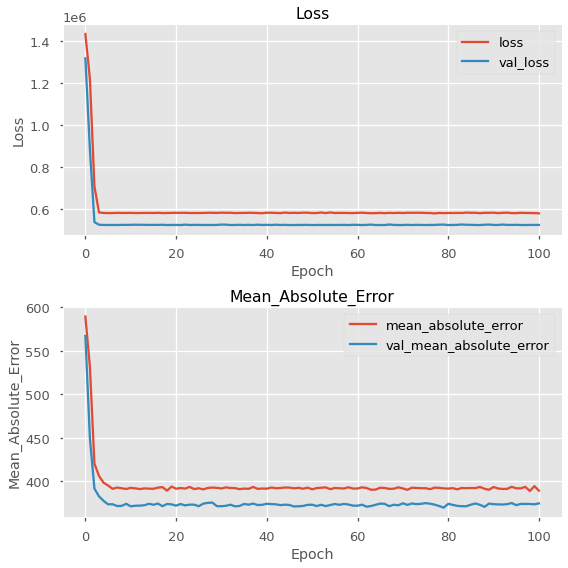

In [40]:
plot_history(history)

In [41]:
test_df = build_general_model_hourly_prediction_df('UBER')[2]

In [42]:
test_df.head(2)

Close_1hour  Close_2hour  Close_3hour  High_1hour  High_2hour  High_3hour  \
0       38.100       38.185        38.12      38.395       38.30       38.19   
1       38.185       38.120        38.19      38.300       38.19       38.37   

   Low_1hour  Low_2hour  Low_3hour  Vol_1hour  Vol_2hour  Vol_3hour  value  \
0     38.035      37.95      37.76    5626508    2727132    2565031  38.32   
1     37.950      37.76      37.66    2727132    2565031    3466715  38.10   

                  Time  
0  2021-12-02 16:00:00  
1  2021-12-02 15:00:00

In [43]:
X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [44]:
preds = model.predict(X)

In [45]:
len(X), len(y), len(preds)

(381, 381, 381)

In [46]:
preds.shape

(381, 12, 1)

In [47]:
y.shape

(381,)

In [48]:
y[0]

38.32

In [49]:
ys = []
for prediction in preds:
    ys.append(np.mean(prediction))

In [50]:
time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(ys)+list(y)

In [51]:
eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data

In [52]:
idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [53]:
eval_df.head(3)

price    category                 time
0  200.313950  prediction  2021-12-02 16:00:00
1  144.191452  prediction  2021-12-02 15:00:00
2  157.866837  prediction  2021-12-02 14:00:00

In [54]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, ys))))

MAE is 748.6504890571764


In [55]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### It's clear that the model is over predicting because the training label data has such a wide range. To mitigate this I will develop models based on price ranges. To determine these range I will see what distribution of stock prices looks like. 

In [56]:
all_symbols = fmpsdk.available_traded_list(apikey)

In [57]:
len(all_symbols)

31855

In [58]:
type(all_symbols)

list

In [59]:
all_symbols[0]

{'symbol': 'SPY',
 'name': 'SPDR S&P 500 ETF Trust',
 'price': 457.4,
 'exchange': 'New York Stock Exchange Arca',
 'exchangeShortName': 'AMEX'}

In [60]:
price_list = []
for symbol in all_symbols:
    price_list.append(symbol['price'])

In [61]:
print('Average stock price')
np.mean(price_list)

Average stock price


1815.964065295872

In [62]:
print('Median Stock Price')
np.median(price_list)

Median Stock Price


24.6

In [63]:
count = 0
for price in price_list:
    if price > 1000:
        count +=1
print('There are '+str(count)+' stocks above $1000')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 2548 stocks above $1000
Which is 7.998744310155391% of the total


In [64]:
count = 0
for price in price_list:
    if price > 1500:
        count +=1
print('There are '+str(count)+' stocks above $1500')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 2065 stocks above $1500
Which is 6.48249882279077% of the total


In [65]:
count = 0
for price in price_list:
    if price > 500:
        count +=1
print('There are '+str(count)+' stocks above $500')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 3420 stocks above $500
Which is 10.736148171401663% of the total


In [66]:
count = 0
for price in price_list:
    if price < 10:
        count +=1
print('There are '+str(count)+' stocks less than $10')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 9892 stocks less than $10
Which is 31.05320985716528% of the total


#### First, I will make a model that is in the range 0-10. This network will be called the penny stock.

In [67]:
penny_symbols = []
for symbol in all_symbols:
    if symbol['price'] < 10:
        penny_symbols.append(symbol['symbol'])

In [68]:
len(penny_symbols)

9892

In [69]:
penny_train_df = build_general_model_hourly_prediction_df(
                        penny_symbols[1])[2]

counter = 0
for sym in penny_symbols[250:300]:
    counter += 1
    print(counter)
    df = build_general_model_hourly_prediction_df(sym)[2]
    penny_train_df = penny_train_df.append(df)
penny_train_df.reset_index(drop = True, inplace = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [70]:
X = penny_train_df.drop(columns = ['Time', 'value'])
y = penny_train_df['value']

y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [71]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



# penny_model = Sequential()
# #Adding the first LSTM layer and some Dropout regularisation
# penny_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
# penny_model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
# penny_model.add(LSTM(units = 50, return_sequences = True))
# penny_model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# penny_model.add(LSTM(units = 50, return_sequences = True))
# penny_model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# penny_model.add(LSTM(units = 50))
# penny_model.add(Dropout(0.2))
# # Adding the output layer
# penny_model.add(Dense(units = 1))

# # Compiling the RNN
# penny_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
#              metrics=['mean_absolute_error'])

# # Fitting the RNN to the Training set
# penny_history = penny_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
#          validation_data = (X_test_scaled, y_test),  
#         callbacks=[EarlyStopping(patience=25, restore_best_weights=True)])




penny_model = Sequential()
#Adding the first layer
penny_model.add(Dense(units = 50, input_shape = (X_train_scaled.shape[1], 1)))
penny_model.add(Dense(units = 100, activation = 'relu'))
penny_model.add(Dropout(0.1))
penny_model.add(Dense(units = 1, activation = 'relu'))

# Compiling 
penny_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting 
penny_history = penny_model.fit(X_train_scaled, y_train, epochs = 850, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=50, restore_best_weights=True)])




Epoch 1/850
459/459 [==============================] - 1s 3ms/step - loss: 11.3178 - mean_absolute_error: 1.8947 - val_loss: 5.2119 - val_mean_absolute_error: 1.1701
Epoch 2/850
459/459 [==============================] - 1s 1ms/step - loss: 4.8438 - mean_absolute_error: 1.1829 - val_loss: 4.5370 - val_mean_absolute_error: 1.0808
Epoch 3/850
459/459 [==============================] - 1s 1ms/step - loss: 4.5893 - mean_absolute_error: 1.1976 - val_loss: 4.3832 - val_mean_absolute_error: 1.2137
Epoch 4/850
459/459 [==============================] - 1s 1ms/step - loss: 4.3817 - mean_absolute_error: 1.1892 - val_loss: 4.1195 - val_mean_absolute_error: 1.1306
Epoch 5/850
459/459 [==============================] - 1s 1ms/step - loss: 4.2673 - mean_absolute_error: 1.1554 - val_loss: 3.9857 - val_mean_absolute_error: 0.9406
Epoch 6/850
459/459 [==============================] - 1s 1ms/step - loss: 4.1614 - mean_absolute_error: 1.1167 - val_loss: 3.8815 - val_mean_absolute_error: 0.9547
Epoch 7/8

459/459 [==============================] - 1s 1ms/step - loss: 3.9108 - mean_absolute_error: 0.9971 - val_loss: 3.8048 - val_mean_absolute_error: 0.9250
Epoch 51/850
459/459 [==============================] - 1s 1ms/step - loss: 3.9092 - mean_absolute_error: 0.9969 - val_loss: 3.8565 - val_mean_absolute_error: 0.9771
Epoch 52/850
459/459 [==============================] - 1s 1ms/step - loss: 3.9173 - mean_absolute_error: 0.9983 - val_loss: 3.8029 - val_mean_absolute_error: 0.9247
Epoch 53/850
459/459 [==============================] - 1s 1ms/step - loss: 3.9182 - mean_absolute_error: 0.9986 - val_loss: 3.8075 - val_mean_absolute_error: 0.9197
Epoch 54/850
459/459 [==============================] - 1s 1ms/step - loss: 3.9121 - mean_absolute_error: 0.9957 - val_loss: 3.9041 - val_mean_absolute_error: 1.0053
Epoch 55/850
459/459 [==============================] - 1s 1ms/step - loss: 3.9195 - mean_absolute_error: 0.9991 - val_loss: 3.8138 - val_mean_absolute_error: 0.9424
Epoch 56/850
459/

459/459 [==============================] - 1s 2ms/step - loss: 3.8835 - mean_absolute_error: 0.9804 - val_loss: 3.8004 - val_mean_absolute_error: 0.9199
Epoch 100/850
459/459 [==============================] - 1s 2ms/step - loss: 3.8884 - mean_absolute_error: 0.9824 - val_loss: 3.7993 - val_mean_absolute_error: 0.9007
Epoch 101/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8910 - mean_absolute_error: 0.9861 - val_loss: 3.8303 - val_mean_absolute_error: 0.9326
Epoch 102/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8916 - mean_absolute_error: 0.9817 - val_loss: 3.8019 - val_mean_absolute_error: 0.9098
Epoch 103/850
459/459 [==============================] - 1s 2ms/step - loss: 3.8870 - mean_absolute_error: 0.9815 - val_loss: 3.8107 - val_mean_absolute_error: 0.9383
Epoch 104/850
459/459 [==============================] - 1s 2ms/step - loss: 3.8844 - mean_absolute_error: 0.9843 - val_loss: 3.8243 - val_mean_absolute_error: 0.9291
Epoch 105/85

459/459 [==============================] - 1s 1ms/step - loss: 3.8626 - mean_absolute_error: 0.9689 - val_loss: 3.8656 - val_mean_absolute_error: 0.9985
Epoch 149/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8684 - mean_absolute_error: 0.9733 - val_loss: 3.8042 - val_mean_absolute_error: 0.8996
Epoch 150/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8703 - mean_absolute_error: 0.9724 - val_loss: 3.8319 - val_mean_absolute_error: 0.9523
Epoch 151/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8605 - mean_absolute_error: 0.9719 - val_loss: 3.8157 - val_mean_absolute_error: 0.9279
Epoch 152/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8599 - mean_absolute_error: 0.9697 - val_loss: 3.8087 - val_mean_absolute_error: 0.9190
Epoch 153/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8699 - mean_absolute_error: 0.9742 - val_loss: 3.7929 - val_mean_absolute_error: 0.9202
Epoch 154/85

459/459 [==============================] - 1s 1ms/step - loss: 3.8532 - mean_absolute_error: 0.9671 - val_loss: 3.7913 - val_mean_absolute_error: 0.9279
Epoch 198/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8533 - mean_absolute_error: 0.9668 - val_loss: 3.7959 - val_mean_absolute_error: 0.9452
Epoch 199/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8595 - mean_absolute_error: 0.9724 - val_loss: 3.8503 - val_mean_absolute_error: 0.8652
Epoch 200/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8528 - mean_absolute_error: 0.9626 - val_loss: 3.8006 - val_mean_absolute_error: 0.9264
Epoch 201/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8474 - mean_absolute_error: 0.9681 - val_loss: 3.8064 - val_mean_absolute_error: 0.9078
Epoch 202/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8514 - mean_absolute_error: 0.9691 - val_loss: 3.7890 - val_mean_absolute_error: 0.9014
Epoch 203/85

459/459 [==============================] - 1s 1ms/step - loss: 3.8489 - mean_absolute_error: 0.9671 - val_loss: 3.7957 - val_mean_absolute_error: 0.9180
Epoch 247/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8543 - mean_absolute_error: 0.9661 - val_loss: 3.7953 - val_mean_absolute_error: 0.8977
Epoch 248/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8455 - mean_absolute_error: 0.9660 - val_loss: 3.7941 - val_mean_absolute_error: 0.9392
Epoch 249/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8408 - mean_absolute_error: 0.9676 - val_loss: 3.7929 - val_mean_absolute_error: 0.9072
Epoch 250/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8416 - mean_absolute_error: 0.9645 - val_loss: 3.8006 - val_mean_absolute_error: 0.9151
Epoch 251/850
459/459 [==============================] - 1s 1ms/step - loss: 3.8551 - mean_absolute_error: 0.9645 - val_loss: 3.7927 - val_mean_absolute_error: 0.9201
Epoch 252/85

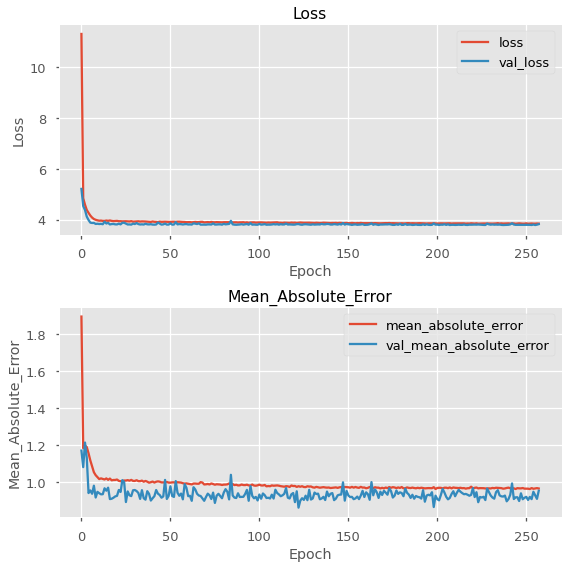

In [72]:
plot_history(penny_history)

In [73]:
penny_symbols[1200]

'SMED'

In [74]:
test_df = build_general_model_hourly_prediction_df(penny_symbols[1200])[2]

X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [75]:
preds = penny_model.predict(X)

# preds = preds.reshape(y.shape)
# preds = pd.Series(preds)
penny_ys = []
for prediction in preds:
    penny_ys.append(np.mean(prediction))


time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(penny_ys)+list(y)

eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data
for prediction in preds:
    ys.append(np.mean(prediction))

idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [76]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, penny_ys))))

MAE is 2.858261751351746


In [77]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### This already looks much closer than the previous model. Because penny stocks make up 31% of the total, I will start by making two additional models that will make up the rest. The first model will be called the meh_stock_model. The meh_stock_model will be trained on stocks between 10-50 dollars.

In [78]:
count = 0
for price in price_list:
    if (price > 10) & (price <50):
        count +=1
print('There are '+str(count)+' stocks greater than $10 but less than $50')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 11526 stocks greater than $10 but less than $50
Which is 36.18270287239052% of the total


In [79]:
count = 0
for price in price_list:
    if price > 50:
        count +=1
print('There are '+str(count)+' stocks greater than $50')
percent = count / len(price_list)
print('Which is '+str(percent*100)+'% of the total')

There are 10382 stocks greater than $50
Which is 32.59142991681055% of the total


In [80]:
meh_symbols = []
for symbol in all_symbols:
    if (symbol['price'] > 10) & (symbol['price'] < 50):
        meh_symbols.append(symbol['symbol'])

In [81]:
len(meh_symbols)

11526

In [82]:
meh_train_df = build_general_model_hourly_prediction_df(
                        meh_symbols[1])[2]

counter = 0
for sym in meh_symbols[250:300]:
    counter += 1
    print(counter)
    df = build_general_model_hourly_prediction_df(sym)[2]
    meh_train_df = meh_train_df.append(df)
meh_train_df.reset_index(drop = True, inplace = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [83]:
X = meh_train_df.drop(columns = ['Time', 'value'])
y = meh_train_df['value']

y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [84]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



# meh_model = Sequential()
# #Adding the first LSTM layer and some Dropout regularisation
# meh_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
# meh_model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
# meh_model.add(LSTM(units = 50, return_sequences = True))
# meh_model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# meh_model.add(LSTM(units = 50, return_sequences = True))
# meh_model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# meh_model.add(LSTM(units = 50))
# meh_model.add(Dropout(0.2))
# # Adding the output layer
# meh_model.add(Dense(units = 1))

# # Compiling the RNN
# meh_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
#              metrics=['mean_absolute_error'])

# # Fitting the RNN to the Training set
# meh_history = meh_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
#          validation_data = (X_test_scaled, y_test),  
#         callbacks=[EarlyStopping(patience=25, restore_best_weights=True)])


meh_model = Sequential()
#Adding the first layer
meh_model.add(Dense(units = 50, input_shape = (X_train_scaled.shape[1], 1)))
meh_model.add(Dense(units = 100, activation = 'relu'))
meh_model.add(Dropout(0.1))
meh_model.add(Dense(units = 1, activation = 'relu'))

# Compiling 
meh_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting
meh_history = meh_model.fit(X_train_scaled, y_train, epochs = 850, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=50, restore_best_weights=True)])



Epoch 1/850
473/473 [==============================] - 1s 2ms/step - loss: 212.6546 - mean_absolute_error: 9.3542 - val_loss: 44.4223 - val_mean_absolute_error: 3.5395
Epoch 2/850
473/473 [==============================] - 1s 1ms/step - loss: 43.7952 - mean_absolute_error: 3.8968 - val_loss: 38.9447 - val_mean_absolute_error: 3.3317
Epoch 3/850
473/473 [==============================] - 1s 1ms/step - loss: 40.3578 - mean_absolute_error: 3.8641 - val_loss: 35.5984 - val_mean_absolute_error: 3.1992
Epoch 4/850
473/473 [==============================] - 1s 1ms/step - loss: 39.1682 - mean_absolute_error: 3.7943 - val_loss: 34.4808 - val_mean_absolute_error: 3.0712
Epoch 5/850
473/473 [==============================] - 1s 1ms/step - loss: 37.9758 - mean_absolute_error: 3.6896 - val_loss: 33.7908 - val_mean_absolute_error: 2.8867
Epoch 6/850
473/473 [==============================] - 1s 1ms/step - loss: 37.0351 - mean_absolute_error: 3.5561 - val_loss: 33.3779 - val_mean_absolute_error: 2.90

Epoch 50/850
473/473 [==============================] - 1s 1ms/step - loss: 35.2600 - mean_absolute_error: 3.1805 - val_loss: 33.1387 - val_mean_absolute_error: 2.8333
Epoch 51/850
473/473 [==============================] - 1s 1ms/step - loss: 35.3351 - mean_absolute_error: 3.1929 - val_loss: 33.1058 - val_mean_absolute_error: 2.7809
Epoch 52/850
473/473 [==============================] - 1s 1ms/step - loss: 35.2726 - mean_absolute_error: 3.1945 - val_loss: 33.1697 - val_mean_absolute_error: 2.7215
Epoch 53/850
473/473 [==============================] - 1s 1ms/step - loss: 35.2867 - mean_absolute_error: 3.1849 - val_loss: 33.0743 - val_mean_absolute_error: 2.7830
Epoch 54/850
473/473 [==============================] - 1s 1ms/step - loss: 35.3563 - mean_absolute_error: 3.2019 - val_loss: 33.1254 - val_mean_absolute_error: 2.7602
Epoch 55/850
473/473 [==============================] - 1s 1ms/step - loss: 35.3018 - mean_absolute_error: 3.1866 - val_loss: 33.2145 - val_mean_absolute_error:

In [85]:
meh_symbols[1200]

'TDTT'

In [86]:
test_df = build_general_model_hourly_prediction_df(meh_symbols[1200])[2]

X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [87]:
preds = meh_model.predict(X)

# preds = preds.reshape(y.shape)
# preds = pd.Series(preds)



meh_ys = []
for prediction in preds:
    meh_ys.append(np.mean(prediction))

time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(meh_ys)+list(y)




eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data






idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [88]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [89]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, meh_ys))))

MAE is 7.892002428852525


#### The last model will make up stocks that are greater than $50 and will be called the phat_model.

In [90]:
phat_symbols = []
for symbol in all_symbols:
    if symbol['price'] > 50:
        phat_symbols.append(symbol['symbol'])

In [91]:
len(phat_symbols)

10382

In [92]:
phat_train_df = build_general_model_hourly_prediction_df(
                        phat_symbols[1])[2]

counter = 0
for sym in phat_symbols[250:300]:
    counter += 1
    print(counter)
    df = build_general_model_hourly_prediction_df(sym)[2]
    phat_train_df = phat_train_df.append(df)
phat_train_df.reset_index(drop = True, inplace = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [93]:
X = phat_train_df.drop(columns = ['Time', 'value'])
y = phat_train_df['value']

y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


sc = StandardScaler()
special_sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [94]:
X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0],X_test.shape[1] , 1)



# phat_model = Sequential()
# #Adding the first LSTM layer and some Dropout regularisation
# phat_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
# phat_model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
# phat_model.add(LSTM(units = 50, return_sequences = True))
# phat_model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# phat_model.add(LSTM(units = 50, return_sequences = True))
# phat_model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# phat_model.add(LSTM(units = 50))
# phat_model.add(Dropout(0.2))
# # Adding the output layer
# phat_model.add(Dense(units = 1))

# # Compiling the RNN
# phat_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
#              metrics=['mean_absolute_error'])

# # Fitting the RNN to the Training set
# phat_history = phat_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
#          validation_data = (X_test_scaled, y_test),  
#         callbacks=[EarlyStopping(patience=25, restore_best_weights=True)])

phat_model = Sequential()

phat_model.add(Dense(units = 50, input_shape = (X_train_scaled.shape[1], 1)))
phat_model.add(Dense(units = 100, activation = 'relu'))
phat_model.add(Dropout(0.1))
phat_model.add(Dense(units = 1, activation = 'relu'))

# Compiling
phat_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting 
phat_history = phat_model.fit(X_train_scaled, y_train, epochs = 850, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=30, restore_best_weights=True)])




Epoch 1/850
477/477 [==============================] - 1s 2ms/step - loss: 162413.5312 - mean_absolute_error: 163.1514 - val_loss: 76095.8906 - val_mean_absolute_error: 112.0258
Epoch 2/850
477/477 [==============================] - 1s 1ms/step - loss: 78870.0625 - mean_absolute_error: 104.2636 - val_loss: 67735.3359 - val_mean_absolute_error: 96.9506
Epoch 3/850
477/477 [==============================] - 1s 1ms/step - loss: 77221.0938 - mean_absolute_error: 101.2048 - val_loss: 67606.9297 - val_mean_absolute_error: 99.8135
Epoch 4/850
477/477 [==============================] - 1s 1ms/step - loss: 77475.4375 - mean_absolute_error: 102.1973 - val_loss: 67884.8203 - val_mean_absolute_error: 95.9977
Epoch 5/850
477/477 [==============================] - 1s 1ms/step - loss: 77469.4844 - mean_absolute_error: 101.8547 - val_loss: 68026.5000 - val_mean_absolute_error: 97.4576
Epoch 6/850
477/477 [==============================] - 1s 1ms/step - loss: 77262.9297 - mean_absolute_error: 101.5933 

477/477 [==============================] - 1s 1ms/step - loss: 77095.5781 - mean_absolute_error: 99.8158 - val_loss: 67315.3750 - val_mean_absolute_error: 95.6680
Epoch 48/850
477/477 [==============================] - 1s 2ms/step - loss: 76816.5625 - mean_absolute_error: 99.6440 - val_loss: 67765.7891 - val_mean_absolute_error: 95.0793
Epoch 49/850
477/477 [==============================] - 1s 1ms/step - loss: 76738.8281 - mean_absolute_error: 99.5218 - val_loss: 67173.4375 - val_mean_absolute_error: 94.5931
Epoch 50/850
477/477 [==============================] - 1s 1ms/step - loss: 76739.9062 - mean_absolute_error: 99.4662 - val_loss: 67088.7812 - val_mean_absolute_error: 92.7521
Epoch 51/850
477/477 [==============================] - 1s 2ms/step - loss: 76508.9609 - mean_absolute_error: 99.3116 - val_loss: 67261.1484 - val_mean_absolute_error: 93.1724
Epoch 52/850
477/477 [==============================] - 1s 3ms/step - loss: 76686.2031 - mean_absolute_error: 99.0426 - val_loss: 670

477/477 [==============================] - 1s 1ms/step - loss: 76186.5547 - mean_absolute_error: 98.7985 - val_loss: 65883.5938 - val_mean_absolute_error: 91.8873
Epoch 94/850
477/477 [==============================] - 1s 1ms/step - loss: 75572.5859 - mean_absolute_error: 98.9714 - val_loss: 65828.8125 - val_mean_absolute_error: 91.3757
Epoch 95/850
477/477 [==============================] - 1s 1ms/step - loss: 75839.1953 - mean_absolute_error: 99.3003 - val_loss: 66293.0859 - val_mean_absolute_error: 90.5357
Epoch 96/850
477/477 [==============================] - 1s 1ms/step - loss: 75958.9219 - mean_absolute_error: 98.8392 - val_loss: 65998.8750 - val_mean_absolute_error: 91.1526
Epoch 97/850
477/477 [==============================] - 1s 1ms/step - loss: 76053.2031 - mean_absolute_error: 99.0113 - val_loss: 65990.7500 - val_mean_absolute_error: 94.0681
Epoch 98/850
477/477 [==============================] - 1s 1ms/step - loss: 76029.7031 - mean_absolute_error: 98.7734 - val_loss: 657

477/477 [==============================] - 1s 1ms/step - loss: 73667.8516 - mean_absolute_error: 93.7949 - val_loss: 63598.2227 - val_mean_absolute_error: 87.2249
Epoch 140/850
477/477 [==============================] - 1s 1ms/step - loss: 74132.0469 - mean_absolute_error: 94.1040 - val_loss: 63604.3047 - val_mean_absolute_error: 86.7393
Epoch 141/850
477/477 [==============================] - 1s 1ms/step - loss: 73830.3750 - mean_absolute_error: 94.1352 - val_loss: 63753.7617 - val_mean_absolute_error: 86.1034
Epoch 142/850
477/477 [==============================] - 1s 1ms/step - loss: 73471.9766 - mean_absolute_error: 93.6385 - val_loss: 63572.6758 - val_mean_absolute_error: 85.0029
Epoch 143/850
477/477 [==============================] - 1s 1ms/step - loss: 73802.7969 - mean_absolute_error: 94.2670 - val_loss: 63842.2031 - val_mean_absolute_error: 86.7869
Epoch 144/850
477/477 [==============================] - 1s 1ms/step - loss: 73820.4062 - mean_absolute_error: 93.7845 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 74139.2891 - mean_absolute_error: 95.2276 - val_loss: 63964.9180 - val_mean_absolute_error: 88.5990
Epoch 186/850
477/477 [==============================] - 1s 1ms/step - loss: 74038.5703 - mean_absolute_error: 94.9775 - val_loss: 63785.1992 - val_mean_absolute_error: 86.9960
Epoch 187/850
477/477 [==============================] - 1s 1ms/step - loss: 73294.7188 - mean_absolute_error: 95.2130 - val_loss: 64517.3477 - val_mean_absolute_error: 91.1843
Epoch 188/850
477/477 [==============================] - 1s 1ms/step - loss: 73491.9375 - mean_absolute_error: 94.5671 - val_loss: 63449.5508 - val_mean_absolute_error: 84.8459
Epoch 189/850
477/477 [==============================] - 1s 1ms/step - loss: 73462.9297 - mean_absolute_error: 95.1714 - val_loss: 63647.0938 - val_mean_absolute_error: 88.3561
Epoch 190/850
477/477 [==============================] - 1s 1ms/step - loss: 73223.4609 - mean_absolute_error: 94.9012 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 74225.7812 - mean_absolute_error: 94.8231 - val_loss: 63631.5781 - val_mean_absolute_error: 86.9132
Epoch 232/850
477/477 [==============================] - 1s 1ms/step - loss: 73623.8672 - mean_absolute_error: 94.5656 - val_loss: 63564.2578 - val_mean_absolute_error: 88.2570
Epoch 233/850
477/477 [==============================] - 1s 1ms/step - loss: 73820.8672 - mean_absolute_error: 94.8383 - val_loss: 63445.2266 - val_mean_absolute_error: 87.0688
Epoch 234/850
477/477 [==============================] - 1s 1ms/step - loss: 74026.1719 - mean_absolute_error: 94.7618 - val_loss: 63391.3359 - val_mean_absolute_error: 87.7686
Epoch 235/850
477/477 [==============================] - 1s 1ms/step - loss: 73681.3594 - mean_absolute_error: 95.0033 - val_loss: 63932.1406 - val_mean_absolute_error: 87.7546
Epoch 236/850
477/477 [==============================] - 1s 1ms/step - loss: 73612.2734 - mean_absolute_error: 94.3088 - val_loss

477/477 [==============================] - 1s 2ms/step - loss: 72756.7578 - mean_absolute_error: 94.0108 - val_loss: 62601.8203 - val_mean_absolute_error: 89.1613
Epoch 278/850
477/477 [==============================] - 1s 1ms/step - loss: 72603.3359 - mean_absolute_error: 94.9474 - val_loss: 63105.6094 - val_mean_absolute_error: 88.1964
Epoch 279/850
477/477 [==============================] - 1s 1ms/step - loss: 73371.5781 - mean_absolute_error: 94.2246 - val_loss: 62747.4883 - val_mean_absolute_error: 93.8970
Epoch 280/850
477/477 [==============================] - 1s 1ms/step - loss: 72583.8594 - mean_absolute_error: 94.6315 - val_loss: 62838.2930 - val_mean_absolute_error: 89.6620
Epoch 281/850
477/477 [==============================] - 1s 1ms/step - loss: 73079.2891 - mean_absolute_error: 94.4806 - val_loss: 62540.5898 - val_mean_absolute_error: 90.5388
Epoch 282/850
477/477 [==============================] - 1s 1ms/step - loss: 72410.5547 - mean_absolute_error: 94.6727 - val_loss

477/477 [==============================] - 1s 2ms/step - loss: 62370.1641 - mean_absolute_error: 91.1471 - val_loss: 53670.2539 - val_mean_absolute_error: 83.6492
Epoch 324/850
477/477 [==============================] - 1s 1ms/step - loss: 62458.1602 - mean_absolute_error: 90.9145 - val_loss: 53056.9297 - val_mean_absolute_error: 85.2644
Epoch 325/850
477/477 [==============================] - 1s 1ms/step - loss: 62019.4023 - mean_absolute_error: 90.7929 - val_loss: 53002.2305 - val_mean_absolute_error: 80.9543
Epoch 326/850
477/477 [==============================] - 1s 2ms/step - loss: 63355.0625 - mean_absolute_error: 91.2464 - val_loss: 52167.2383 - val_mean_absolute_error: 80.6142
Epoch 327/850
477/477 [==============================] - 1s 2ms/step - loss: 61452.2500 - mean_absolute_error: 90.4043 - val_loss: 52223.1875 - val_mean_absolute_error: 87.6495
Epoch 328/850
477/477 [==============================] - 1s 1ms/step - loss: 60717.2422 - mean_absolute_error: 90.0702 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 56115.5078 - mean_absolute_error: 87.1995 - val_loss: 45928.7031 - val_mean_absolute_error: 80.0628
Epoch 370/850
477/477 [==============================] - 1s 1ms/step - loss: 56110.3438 - mean_absolute_error: 87.1445 - val_loss: 45932.9570 - val_mean_absolute_error: 77.1811
Epoch 371/850
477/477 [==============================] - 1s 1ms/step - loss: 56254.5547 - mean_absolute_error: 86.7951 - val_loss: 45859.8320 - val_mean_absolute_error: 79.3127
Epoch 372/850
477/477 [==============================] - 1s 1ms/step - loss: 56328.7148 - mean_absolute_error: 86.9438 - val_loss: 45968.9180 - val_mean_absolute_error: 82.3478
Epoch 373/850
477/477 [==============================] - 1s 1ms/step - loss: 55930.0703 - mean_absolute_error: 87.0924 - val_loss: 45690.9844 - val_mean_absolute_error: 78.7052
Epoch 374/850
477/477 [==============================] - 1s 2ms/step - loss: 55894.0977 - mean_absolute_error: 86.9513 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 55451.4648 - mean_absolute_error: 86.3744 - val_loss: 44145.3320 - val_mean_absolute_error: 80.0382
Epoch 416/850
477/477 [==============================] - 1s 1ms/step - loss: 54508.2617 - mean_absolute_error: 86.1979 - val_loss: 44092.2578 - val_mean_absolute_error: 79.3763
Epoch 417/850
477/477 [==============================] - 1s 1ms/step - loss: 54676.6094 - mean_absolute_error: 86.0856 - val_loss: 44049.9688 - val_mean_absolute_error: 78.5614
Epoch 418/850
477/477 [==============================] - 1s 1ms/step - loss: 54286.1016 - mean_absolute_error: 86.0468 - val_loss: 44184.6836 - val_mean_absolute_error: 71.6972
Epoch 419/850
477/477 [==============================] - 1s 1ms/step - loss: 54531.9766 - mean_absolute_error: 86.3339 - val_loss: 43985.3906 - val_mean_absolute_error: 76.1509
Epoch 420/850
477/477 [==============================] - 1s 1ms/step - loss: 54440.8867 - mean_absolute_error: 86.1497 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 54092.8398 - mean_absolute_error: 86.2038 - val_loss: 43591.3984 - val_mean_absolute_error: 72.6400
Epoch 462/850
477/477 [==============================] - 1s 1ms/step - loss: 54001.1953 - mean_absolute_error: 86.0405 - val_loss: 43663.8594 - val_mean_absolute_error: 76.4688
Epoch 463/850
477/477 [==============================] - 1s 1ms/step - loss: 53958.3516 - mean_absolute_error: 86.2691 - val_loss: 43599.4648 - val_mean_absolute_error: 74.1988
Epoch 464/850
477/477 [==============================] - 1s 1ms/step - loss: 54052.9570 - mean_absolute_error: 85.9588 - val_loss: 43673.4961 - val_mean_absolute_error: 80.5441
Epoch 465/850
477/477 [==============================] - 1s 1ms/step - loss: 53728.8086 - mean_absolute_error: 86.0730 - val_loss: 43730.8711 - val_mean_absolute_error: 79.0793
Epoch 466/850
477/477 [==============================] - 1s 1ms/step - loss: 54046.5977 - mean_absolute_error: 86.0210 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 53934.5156 - mean_absolute_error: 85.9739 - val_loss: 43535.1328 - val_mean_absolute_error: 79.8354
Epoch 508/850
477/477 [==============================] - 1s 1ms/step - loss: 53887.2695 - mean_absolute_error: 86.0722 - val_loss: 43366.3945 - val_mean_absolute_error: 75.1101
Epoch 509/850
477/477 [==============================] - 1s 1ms/step - loss: 53998.5273 - mean_absolute_error: 86.0642 - val_loss: 43391.1719 - val_mean_absolute_error: 74.3262
Epoch 510/850
477/477 [==============================] - 1s 1ms/step - loss: 53831.6953 - mean_absolute_error: 85.9129 - val_loss: 43399.9062 - val_mean_absolute_error: 72.2447
Epoch 511/850
477/477 [==============================] - 1s 1ms/step - loss: 53937.2188 - mean_absolute_error: 85.8468 - val_loss: 43525.7305 - val_mean_absolute_error: 80.1404
Epoch 512/850
477/477 [==============================] - 1s 1ms/step - loss: 53772.1172 - mean_absolute_error: 85.9760 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 54008.7773 - mean_absolute_error: 86.2049 - val_loss: 43356.4766 - val_mean_absolute_error: 72.4166
Epoch 554/850
477/477 [==============================] - 1s 1ms/step - loss: 54889.0352 - mean_absolute_error: 86.2777 - val_loss: 43425.8203 - val_mean_absolute_error: 72.0431
Epoch 555/850
477/477 [==============================] - 1s 1ms/step - loss: 54031.2500 - mean_absolute_error: 85.8430 - val_loss: 43405.1602 - val_mean_absolute_error: 77.2950
Epoch 556/850
477/477 [==============================] - 1s 1ms/step - loss: 53857.7930 - mean_absolute_error: 85.8493 - val_loss: 43432.0312 - val_mean_absolute_error: 79.2148
Epoch 557/850
477/477 [==============================] - 1s 1ms/step - loss: 53718.8164 - mean_absolute_error: 85.9186 - val_loss: 43386.2461 - val_mean_absolute_error: 76.9736
Epoch 558/850
477/477 [==============================] - 1s 1ms/step - loss: 53608.9961 - mean_absolute_error: 85.8158 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 53884.5938 - mean_absolute_error: 85.8596 - val_loss: 43434.4766 - val_mean_absolute_error: 79.9091
Epoch 600/850
477/477 [==============================] - 1s 1ms/step - loss: 53744.0547 - mean_absolute_error: 86.1407 - val_loss: 43373.6758 - val_mean_absolute_error: 72.8628
Epoch 601/850
477/477 [==============================] - 1s 1ms/step - loss: 53970.9609 - mean_absolute_error: 86.0648 - val_loss: 43296.9609 - val_mean_absolute_error: 75.2069
Epoch 602/850
477/477 [==============================] - 1s 1ms/step - loss: 53926.9336 - mean_absolute_error: 85.8821 - val_loss: 43361.7070 - val_mean_absolute_error: 76.8068
Epoch 603/850
477/477 [==============================] - 1s 1ms/step - loss: 53865.9219 - mean_absolute_error: 85.8217 - val_loss: 43646.5547 - val_mean_absolute_error: 81.3148
Epoch 604/850
477/477 [==============================] - 1s 1ms/step - loss: 53898.4062 - mean_absolute_error: 86.2596 - val_loss

477/477 [==============================] - 1s 2ms/step - loss: 53628.0977 - mean_absolute_error: 85.9652 - val_loss: 43232.4766 - val_mean_absolute_error: 72.9825
Epoch 646/850
477/477 [==============================] - 1s 2ms/step - loss: 53632.8945 - mean_absolute_error: 85.8687 - val_loss: 43318.6953 - val_mean_absolute_error: 71.2339
Epoch 647/850
477/477 [==============================] - 1s 1ms/step - loss: 53556.0742 - mean_absolute_error: 85.6560 - val_loss: 43240.8906 - val_mean_absolute_error: 73.1321
Epoch 648/850
477/477 [==============================] - 1s 2ms/step - loss: 53653.1172 - mean_absolute_error: 85.9352 - val_loss: 43311.7617 - val_mean_absolute_error: 74.2824
Epoch 649/850
477/477 [==============================] - 1s 2ms/step - loss: 53633.0664 - mean_absolute_error: 85.7376 - val_loss: 43217.9609 - val_mean_absolute_error: 75.5967
Epoch 650/850
477/477 [==============================] - 1s 1ms/step - loss: 53675.0625 - mean_absolute_error: 85.9210 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 53703.6133 - mean_absolute_error: 85.5364 - val_loss: 43196.7852 - val_mean_absolute_error: 75.1000
Epoch 692/850
477/477 [==============================] - 1s 1ms/step - loss: 53537.9062 - mean_absolute_error: 85.6455 - val_loss: 43150.2891 - val_mean_absolute_error: 74.2578
Epoch 693/850
477/477 [==============================] - 1s 1ms/step - loss: 53586.4180 - mean_absolute_error: 85.5584 - val_loss: 43205.7656 - val_mean_absolute_error: 76.7389
Epoch 694/850
477/477 [==============================] - 1s 1ms/step - loss: 53519.3359 - mean_absolute_error: 85.7574 - val_loss: 43135.7812 - val_mean_absolute_error: 74.6040
Epoch 695/850
477/477 [==============================] - 1s 1ms/step - loss: 53541.5508 - mean_absolute_error: 85.5959 - val_loss: 43270.3086 - val_mean_absolute_error: 80.2242
Epoch 696/850
477/477 [==============================] - 1s 1ms/step - loss: 53654.5703 - mean_absolute_error: 85.9742 - val_loss

477/477 [==============================] - 1s 2ms/step - loss: 53557.4023 - mean_absolute_error: 85.9963 - val_loss: 43161.6875 - val_mean_absolute_error: 77.0935
Epoch 738/850
477/477 [==============================] - 1s 2ms/step - loss: 53496.6797 - mean_absolute_error: 85.7890 - val_loss: 43387.2695 - val_mean_absolute_error: 79.9475
Epoch 739/850
477/477 [==============================] - 1s 2ms/step - loss: 53517.9961 - mean_absolute_error: 85.6728 - val_loss: 43266.5508 - val_mean_absolute_error: 79.1168
Epoch 740/850
477/477 [==============================] - 1s 1ms/step - loss: 53436.0352 - mean_absolute_error: 85.5683 - val_loss: 43212.8359 - val_mean_absolute_error: 72.2391
Epoch 741/850
477/477 [==============================] - 1s 1ms/step - loss: 53496.0781 - mean_absolute_error: 85.4641 - val_loss: 43259.5391 - val_mean_absolute_error: 73.0777
Epoch 742/850
477/477 [==============================] - 1s 1ms/step - loss: 53724.4648 - mean_absolute_error: 85.7195 - val_loss

477/477 [==============================] - 1s 2ms/step - loss: 53550.9102 - mean_absolute_error: 85.6081 - val_loss: 43418.2812 - val_mean_absolute_error: 73.5611
Epoch 784/850
477/477 [==============================] - 1s 2ms/step - loss: 53452.5859 - mean_absolute_error: 85.2645 - val_loss: 43254.2344 - val_mean_absolute_error: 78.3453
Epoch 785/850
477/477 [==============================] - 1s 1ms/step - loss: 53529.5938 - mean_absolute_error: 85.6573 - val_loss: 43280.3047 - val_mean_absolute_error: 74.8576
Epoch 786/850
477/477 [==============================] - 1s 2ms/step - loss: 53706.0469 - mean_absolute_error: 86.0414 - val_loss: 43182.8594 - val_mean_absolute_error: 74.5677
Epoch 787/850
477/477 [==============================] - 1s 1ms/step - loss: 53357.1211 - mean_absolute_error: 85.5174 - val_loss: 43228.8281 - val_mean_absolute_error: 76.3981
Epoch 788/850
477/477 [==============================] - 1s 1ms/step - loss: 53519.9141 - mean_absolute_error: 85.4555 - val_loss

477/477 [==============================] - 1s 1ms/step - loss: 53530.9531 - mean_absolute_error: 85.5639 - val_loss: 43234.9023 - val_mean_absolute_error: 76.4495
Epoch 830/850
477/477 [==============================] - 1s 1ms/step - loss: 53291.8047 - mean_absolute_error: 85.5382 - val_loss: 43306.3672 - val_mean_absolute_error: 80.4037
Epoch 831/850
477/477 [==============================] - 1s 2ms/step - loss: 53239.6484 - mean_absolute_error: 85.4607 - val_loss: 43192.8008 - val_mean_absolute_error: 74.6369
Epoch 832/850
477/477 [==============================] - 1s 1ms/step - loss: 53337.6406 - mean_absolute_error: 85.4043 - val_loss: 43167.5234 - val_mean_absolute_error: 79.1805
Epoch 833/850
477/477 [==============================] - 1s 1ms/step - loss: 53462.4453 - mean_absolute_error: 85.6953 - val_loss: 43158.8125 - val_mean_absolute_error: 76.9518
Epoch 834/850
477/477 [==============================] - 1s 1ms/step - loss: 53590.7500 - mean_absolute_error: 85.6334 - val_loss

In [95]:
phat_symbols[1200]

'OTTR'

In [96]:
test_df = build_general_model_hourly_prediction_df(phat_symbols[1200])[2]

X = test_df.drop(columns = ['value', 'Time'])
y = test_df['value']

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X = np.array(X_scaled).reshape(X.shape[0],X.shape[1] , 1)

In [97]:
preds = phat_model.predict(X)

# preds = preds.reshape(y.shape)
# preds = pd.Series(preds)

phat_ys = []
for prediction in preds:
    phat_ys.append(np.mean(prediction))

time_2 = list(test_df.Time)
time = list(test_df.Time)
time_combined = time_2 + time
combined_data = list(phat_ys)+list(y)

eval_df = pd.DataFrame(columns = ['price', 'category', 'time'])
eval_df.time = time_combined
eval_df.price = combined_data

idx = 0
for cat in eval_df.category:
    if idx < X.shape[0]:
        eval_df.category[idx] = 'prediction'
    else:
        eval_df.category[idx] = 'actual_price'
    idx += 1

In [98]:
print('MAE is '+str(np.sqrt(mean_squared_error(y, phat_ys))))

MAE is 338.08127840689195


In [99]:
fig = px.line(eval_df, x='time', y='price', color='category', markers=True, 
             title = 'Actual Stock Price VS Predicted Stock Price Over Time')
fig.update_layout(
   
    yaxis_title="Stock Price",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### Now I will see how a network does when trained on an individual stock.

In [100]:
amzn_df_n = build_general_model_hourly_prediction_df('AMZN')[2]

In [101]:
amzn_df_n.shape

(434, 14)

In [102]:
X = amzn_df_n.drop(columns = ['value', 'Time'])
y = amzn_df_n['value']

In [103]:
X_train = X[0:350]
X_test = X[350:]

y_train = y[0:350]
y_test = y[350:]

X_val = X_train[250:]
X_train = X_train[:250]

y_val = y_train[250:]
y_train = y_train[:250]

In [104]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
X_val_scaled = sc.transform(X_val)

X_train_scaled = np.array(X_train_scaled).reshape(X_train.shape[0],X_train.shape[1] , 1)

X_test_scaled = np.array(X_test_scaled).reshape(X_test.shape[0], X_test.shape[1], 1)

X_val_scaled = np.array(X_val_scaled).reshape(X_val.shape[0], X_val.shape[1], 1)


In [105]:
# amzn_model_n = Sequential()
# #Adding the first LSTM layer and some Dropout regularisation
# amzn_model_n.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
# amzn_model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
# amzn_model.add(LSTM(units = 50, return_sequences = True))
# amzn_model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# amzn_model.add(LSTM(units = 50, return_sequences = True))
# amzn_model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# amzn_model.add(LSTM(units = 50))
# amzn_model.add(Dropout(0.2))
# # Adding the output layer
# amzn_model.add(Dense(units = 1))

# # Compiling the RNN
# amzn_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
#              metrics=['mean_absolute_error'])

# # Fitting the RNN to the Training set
# amzn_history = amzn_model.fit(X_train_scaled, y_train, epochs = 400, batch_size = 32,
#          validation_data = (X_test_scaled, y_test),  
#         callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

idv_model = Sequential()
#Adding the first layer
idv_model.add(Dense(units = 50, input_shape = (X_train_scaled.shape[1], 1)))
idv_model.add(Dense(units = 100, activation = 'relu'))
idv_model.add(Dropout(0.1))
idv_model.add(Dense(units = 1, activation = 'relu'))

# Compiling 
idv_model.compile(optimizer = 'adam', loss = 'mean_squared_error', 
             metrics=['mean_absolute_error'])

# Fitting 
idv_history = idv_model.fit(X_train_scaled, y_train, epochs = 850, batch_size = 32,
         validation_data = (X_test_scaled, y_test),  
        callbacks=[EarlyStopping(patience=50, restore_best_weights=True)])







Epoch 1/850
8/8 [==============================] - 0s 18ms/step - loss: 12032652.0000 - mean_absolute_error: 3467.1387 - val_loss: 11917573.0000 - val_mean_absolute_error: 3451.6763
Epoch 2/850
8/8 [==============================] - 0s 4ms/step - loss: 12029408.0000 - mean_absolute_error: 3466.6733 - val_loss: 11915707.0000 - val_mean_absolute_error: 3451.4050
Epoch 3/850
8/8 [==============================] - 0s 4ms/step - loss: 12026122.0000 - mean_absolute_error: 3466.2021 - val_loss: 11913638.0000 - val_mean_absolute_error: 3451.1042
Epoch 4/850
8/8 [==============================] - 0s 4ms/step - loss: 12022467.0000 - mean_absolute_error: 3465.6765 - val_loss: 11911284.0000 - val_mean_absolute_error: 3450.7622
Epoch 5/850
8/8 [==============================] - 0s 4ms/step - loss: 12018344.0000 - mean_absolute_error: 3465.0842 - val_loss: 11908460.0000 - val_mean_absolute_error: 3450.3516
Epoch 6/850
8/8 [==============================] - 0s 3ms/step - loss: 12013223.0000 - mean_ab

8/8 [==============================] - 0s 3ms/step - loss: 8577007.0000 - mean_absolute_error: 2906.6841 - val_loss: 9137912.0000 - val_mean_absolute_error: 3014.5149
Epoch 47/850
8/8 [==============================] - 0s 3ms/step - loss: 8383620.0000 - mean_absolute_error: 2869.5513 - val_loss: 8969678.0000 - val_mean_absolute_error: 2985.2622
Epoch 48/850
8/8 [==============================] - 0s 3ms/step - loss: 8177594.5000 - mean_absolute_error: 2829.5417 - val_loss: 8799854.0000 - val_mean_absolute_error: 2955.3701
Epoch 49/850
8/8 [==============================] - 0s 3ms/step - loss: 7989735.5000 - mean_absolute_error: 2792.3755 - val_loss: 8628450.0000 - val_mean_absolute_error: 2924.8208
Epoch 50/850
8/8 [==============================] - 0s 3ms/step - loss: 7794391.0000 - mean_absolute_error: 2752.6501 - val_loss: 8451736.0000 - val_mean_absolute_error: 2892.8550
Epoch 51/850
8/8 [==============================] - 0s 3ms/step - loss: 7597305.5000 - mean_absolute_error: 2711.

8/8 [==============================] - 0s 3ms/step - loss: 2535255.7500 - mean_absolute_error: 1378.1194 - val_loss: 2610830.5000 - val_mean_absolute_error: 1504.9589
Epoch 92/850
8/8 [==============================] - 0s 3ms/step - loss: 2468981.7500 - mean_absolute_error: 1360.7197 - val_loss: 2528248.5000 - val_mean_absolute_error: 1480.2864
Epoch 93/850
8/8 [==============================] - 0s 3ms/step - loss: 2414480.5000 - mean_absolute_error: 1343.9235 - val_loss: 2443248.5000 - val_mean_absolute_error: 1454.1770
Epoch 94/850
8/8 [==============================] - 0s 3ms/step - loss: 2336552.0000 - mean_absolute_error: 1324.4941 - val_loss: 2360373.7500 - val_mean_absolute_error: 1428.3899
Epoch 95/850
8/8 [==============================] - 0s 4ms/step - loss: 2267944.7500 - mean_absolute_error: 1302.0396 - val_loss: 2284404.7500 - val_mean_absolute_error: 1405.6566
Epoch 96/850
8/8 [==============================] - 0s 3ms/step - loss: 2187952.2500 - mean_absolute_error: 1278.

Epoch 137/850
8/8 [==============================] - 0s 4ms/step - loss: 194934.6875 - mean_absolute_error: 357.3540 - val_loss: 143605.6719 - val_mean_absolute_error: 337.8526
Epoch 138/850
8/8 [==============================] - 0s 4ms/step - loss: 183970.0469 - mean_absolute_error: 344.1400 - val_loss: 131432.6875 - val_mean_absolute_error: 321.0727
Epoch 139/850
8/8 [==============================] - 0s 4ms/step - loss: 175069.2344 - mean_absolute_error: 335.9262 - val_loss: 120907.4062 - val_mean_absolute_error: 306.3032
Epoch 140/850
8/8 [==============================] - 0s 4ms/step - loss: 166925.1562 - mean_absolute_error: 326.4508 - val_loss: 113375.9062 - val_mean_absolute_error: 296.5351
Epoch 141/850
8/8 [==============================] - 0s 4ms/step - loss: 161782.9375 - mean_absolute_error: 324.4778 - val_loss: 105206.4062 - val_mean_absolute_error: 284.7457
Epoch 142/850
8/8 [==============================] - 0s 4ms/step - loss: 155646.3594 - mean_absolute_error: 314.995

Epoch 184/850
8/8 [==============================] - 0s 3ms/step - loss: 81452.6719 - mean_absolute_error: 225.8536 - val_loss: 15703.7705 - val_mean_absolute_error: 89.8701
Epoch 185/850
8/8 [==============================] - 0s 3ms/step - loss: 80376.8672 - mean_absolute_error: 223.5184 - val_loss: 15401.7109 - val_mean_absolute_error: 89.0712
Epoch 186/850
8/8 [==============================] - 0s 4ms/step - loss: 80517.8750 - mean_absolute_error: 223.8347 - val_loss: 15005.5879 - val_mean_absolute_error: 86.6026
Epoch 187/850
8/8 [==============================] - 0s 3ms/step - loss: 80457.8203 - mean_absolute_error: 224.0689 - val_loss: 14700.8984 - val_mean_absolute_error: 85.1594
Epoch 188/850
8/8 [==============================] - 0s 3ms/step - loss: 80908.6562 - mean_absolute_error: 223.3200 - val_loss: 14301.5332 - val_mean_absolute_error: 82.4089
Epoch 189/850
8/8 [==============================] - 0s 3ms/step - loss: 82657.7812 - mean_absolute_error: 227.9125 - val_loss: 13

8/8 [==============================] - 0s 3ms/step - loss: 67161.9922 - mean_absolute_error: 202.9989 - val_loss: 7659.4561 - val_mean_absolute_error: 52.3502
Epoch 232/850
8/8 [==============================] - 0s 4ms/step - loss: 68839.0312 - mean_absolute_error: 206.0975 - val_loss: 7565.1396 - val_mean_absolute_error: 52.5919
Epoch 233/850
8/8 [==============================] - 0s 3ms/step - loss: 67257.5859 - mean_absolute_error: 202.8130 - val_loss: 7483.2739 - val_mean_absolute_error: 53.0942
Epoch 234/850
8/8 [==============================] - 0s 3ms/step - loss: 70361.3438 - mean_absolute_error: 206.1426 - val_loss: 7407.9883 - val_mean_absolute_error: 51.6202
Epoch 235/850
8/8 [==============================] - 0s 4ms/step - loss: 72555.1094 - mean_absolute_error: 209.1877 - val_loss: 7337.3711 - val_mean_absolute_error: 51.2541
Epoch 236/850
8/8 [==============================] - 0s 3ms/step - loss: 69242.4922 - mean_absolute_error: 204.0746 - val_loss: 7266.3340 - val_mean_

8/8 [==============================] - 0s 4ms/step - loss: 60932.7305 - mean_absolute_error: 192.4868 - val_loss: 4954.2661 - val_mean_absolute_error: 44.1421
Epoch 279/850
8/8 [==============================] - 0s 4ms/step - loss: 64078.4805 - mean_absolute_error: 193.4122 - val_loss: 5008.7202 - val_mean_absolute_error: 44.6554
Epoch 280/850
8/8 [==============================] - 0s 4ms/step - loss: 62919.2461 - mean_absolute_error: 194.8722 - val_loss: 5070.2769 - val_mean_absolute_error: 45.1839
Epoch 281/850
8/8 [==============================] - 0s 5ms/step - loss: 63006.6836 - mean_absolute_error: 193.0706 - val_loss: 5107.0342 - val_mean_absolute_error: 45.8066
Epoch 282/850
8/8 [==============================] - 0s 5ms/step - loss: 64973.0781 - mean_absolute_error: 198.3107 - val_loss: 5050.0654 - val_mean_absolute_error: 45.4853
Epoch 283/850
8/8 [==============================] - 0s 5ms/step - loss: 64345.9922 - mean_absolute_error: 195.3307 - val_loss: 4934.1821 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 59205.4453 - mean_absolute_error: 189.3619 - val_loss: 4411.0581 - val_mean_absolute_error: 45.6312
Epoch 326/850
8/8 [==============================] - 0s 3ms/step - loss: 56527.7891 - mean_absolute_error: 184.3780 - val_loss: 4397.4243 - val_mean_absolute_error: 45.5664
Epoch 327/850
8/8 [==============================] - 0s 3ms/step - loss: 59215.7383 - mean_absolute_error: 190.1745 - val_loss: 4188.5869 - val_mean_absolute_error: 43.7404
Epoch 328/850
8/8 [==============================] - 0s 3ms/step - loss: 59039.8594 - mean_absolute_error: 186.9847 - val_loss: 4198.1240 - val_mean_absolute_error: 43.6292
Epoch 329/850
8/8 [==============================] - 0s 4ms/step - loss: 57313.6523 - mean_absolute_error: 186.4411 - val_loss: 4273.0522 - val_mean_absolute_error: 44.2358
Epoch 330/850
8/8 [==============================] - 0s 3ms/step - loss: 59458.4297 - mean_absolute_error: 188.5084 - val_loss: 4469.6660 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 54436.2773 - mean_absolute_error: 183.1805 - val_loss: 3772.4441 - val_mean_absolute_error: 42.5307
Epoch 373/850
8/8 [==============================] - 0s 3ms/step - loss: 55984.1133 - mean_absolute_error: 183.2777 - val_loss: 3681.3479 - val_mean_absolute_error: 41.9962
Epoch 374/850
8/8 [==============================] - 0s 3ms/step - loss: 55116.4805 - mean_absolute_error: 180.8744 - val_loss: 3691.8687 - val_mean_absolute_error: 42.2473
Epoch 375/850
8/8 [==============================] - 0s 3ms/step - loss: 50520.8086 - mean_absolute_error: 176.9542 - val_loss: 3659.2373 - val_mean_absolute_error: 42.3623
Epoch 376/850
8/8 [==============================] - 0s 3ms/step - loss: 52767.3516 - mean_absolute_error: 179.0733 - val_loss: 3638.7009 - val_mean_absolute_error: 42.3397
Epoch 377/850
8/8 [==============================] - 0s 3ms/step - loss: 56539.5117 - mean_absolute_error: 183.6193 - val_loss: 3577.1003 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 49306.2461 - mean_absolute_error: 172.7259 - val_loss: 3295.8694 - val_mean_absolute_error: 40.6429
Epoch 420/850
8/8 [==============================] - 0s 3ms/step - loss: 49015.9805 - mean_absolute_error: 171.0857 - val_loss: 3365.0879 - val_mean_absolute_error: 40.9303
Epoch 421/850
8/8 [==============================] - 0s 3ms/step - loss: 51671.8906 - mean_absolute_error: 175.3175 - val_loss: 3425.7615 - val_mean_absolute_error: 41.1781
Epoch 422/850
8/8 [==============================] - 0s 3ms/step - loss: 47288.3750 - mean_absolute_error: 168.1973 - val_loss: 3473.9238 - val_mean_absolute_error: 41.4121
Epoch 423/850
8/8 [==============================] - 0s 3ms/step - loss: 46674.5547 - mean_absolute_error: 168.6868 - val_loss: 3473.9255 - val_mean_absolute_error: 41.2423
Epoch 424/850
8/8 [==============================] - 0s 3ms/step - loss: 48090.1992 - mean_absolute_error: 171.7051 - val_loss: 3413.8564 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 46771.1914 - mean_absolute_error: 169.4722 - val_loss: 3224.8511 - val_mean_absolute_error: 40.4674
Epoch 467/850
8/8 [==============================] - 0s 3ms/step - loss: 45325.8984 - mean_absolute_error: 167.8455 - val_loss: 3262.8645 - val_mean_absolute_error: 40.7337
Epoch 468/850
8/8 [==============================] - 0s 3ms/step - loss: 47131.5547 - mean_absolute_error: 169.1603 - val_loss: 3301.7754 - val_mean_absolute_error: 41.1454
Epoch 469/850
8/8 [==============================] - 0s 3ms/step - loss: 46553.7188 - mean_absolute_error: 168.2666 - val_loss: 3321.7649 - val_mean_absolute_error: 41.1951
Epoch 470/850
8/8 [==============================] - 0s 4ms/step - loss: 45705.0234 - mean_absolute_error: 168.2437 - val_loss: 3254.0386 - val_mean_absolute_error: 40.6578
Epoch 471/850
8/8 [==============================] - 0s 3ms/step - loss: 45834.7812 - mean_absolute_error: 169.0129 - val_loss: 3231.1719 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 42117.6094 - mean_absolute_error: 160.0667 - val_loss: 3043.2764 - val_mean_absolute_error: 38.4876
Epoch 514/850
8/8 [==============================] - 0s 3ms/step - loss: 42557.9727 - mean_absolute_error: 159.8520 - val_loss: 3057.6775 - val_mean_absolute_error: 38.5735
Epoch 515/850
8/8 [==============================] - 0s 5ms/step - loss: 40396.3164 - mean_absolute_error: 157.3556 - val_loss: 3057.0557 - val_mean_absolute_error: 38.8881
Epoch 516/850
8/8 [==============================] - 0s 3ms/step - loss: 43265.4570 - mean_absolute_error: 161.5596 - val_loss: 3053.9241 - val_mean_absolute_error: 38.6935
Epoch 517/850
8/8 [==============================] - 0s 5ms/step - loss: 41191.5195 - mean_absolute_error: 157.7420 - val_loss: 3052.7593 - val_mean_absolute_error: 38.1393
Epoch 518/850
8/8 [==============================] - 0s 3ms/step - loss: 42050.7070 - mean_absolute_error: 160.2517 - val_loss: 3101.6357 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 41058.1016 - mean_absolute_error: 159.3332 - val_loss: 2914.9753 - val_mean_absolute_error: 36.3103
Epoch 561/850
8/8 [==============================] - 0s 3ms/step - loss: 38941.2930 - mean_absolute_error: 154.2828 - val_loss: 2896.5989 - val_mean_absolute_error: 36.9052
Epoch 562/850
8/8 [==============================] - 0s 3ms/step - loss: 38082.9414 - mean_absolute_error: 150.7651 - val_loss: 2882.9277 - val_mean_absolute_error: 36.6742
Epoch 563/850
8/8 [==============================] - 0s 3ms/step - loss: 38956.8633 - mean_absolute_error: 154.6900 - val_loss: 2861.4771 - val_mean_absolute_error: 35.8167
Epoch 564/850
8/8 [==============================] - 0s 3ms/step - loss: 40140.1367 - mean_absolute_error: 156.8731 - val_loss: 2845.5493 - val_mean_absolute_error: 35.3218
Epoch 565/850
8/8 [==============================] - 0s 3ms/step - loss: 38177.1758 - mean_absolute_error: 155.3385 - val_loss: 2935.3372 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 36229.2773 - mean_absolute_error: 150.0435 - val_loss: 2829.9978 - val_mean_absolute_error: 34.3497
Epoch 608/850
8/8 [==============================] - 0s 3ms/step - loss: 36421.3203 - mean_absolute_error: 150.1883 - val_loss: 2814.5217 - val_mean_absolute_error: 34.6526
Epoch 609/850
8/8 [==============================] - 0s 3ms/step - loss: 38170.5312 - mean_absolute_error: 151.7849 - val_loss: 2808.9375 - val_mean_absolute_error: 34.5907
Epoch 610/850
8/8 [==============================] - 0s 3ms/step - loss: 35076.8516 - mean_absolute_error: 148.5644 - val_loss: 2812.5901 - val_mean_absolute_error: 35.2611
Epoch 611/850
8/8 [==============================] - 0s 3ms/step - loss: 34568.6484 - mean_absolute_error: 144.8254 - val_loss: 2833.8977 - val_mean_absolute_error: 36.2623
Epoch 612/850
8/8 [==============================] - 0s 3ms/step - loss: 37135.9688 - mean_absolute_error: 151.0147 - val_loss: 2858.9082 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 33753.6797 - mean_absolute_error: 145.2225 - val_loss: 2859.4722 - val_mean_absolute_error: 37.1808
Epoch 655/850
8/8 [==============================] - 0s 3ms/step - loss: 34078.3750 - mean_absolute_error: 145.8093 - val_loss: 2773.7874 - val_mean_absolute_error: 35.4662
Epoch 656/850
8/8 [==============================] - 0s 3ms/step - loss: 35111.2773 - mean_absolute_error: 147.7241 - val_loss: 2751.5750 - val_mean_absolute_error: 34.2955
Epoch 657/850
8/8 [==============================] - 0s 3ms/step - loss: 34405.4102 - mean_absolute_error: 146.4220 - val_loss: 2783.8894 - val_mean_absolute_error: 35.1274
Epoch 658/850
8/8 [==============================] - 0s 3ms/step - loss: 34023.4102 - mean_absolute_error: 143.7045 - val_loss: 2799.1653 - val_mean_absolute_error: 35.6908
Epoch 659/850
8/8 [==============================] - 0s 3ms/step - loss: 35515.6523 - mean_absolute_error: 148.0849 - val_loss: 2810.0208 - val_mean_

8/8 [==============================] - 0s 3ms/step - loss: 33595.1953 - mean_absolute_error: 145.0217 - val_loss: 2801.2227 - val_mean_absolute_error: 34.5437
Epoch 702/850
8/8 [==============================] - 0s 3ms/step - loss: 34080.2930 - mean_absolute_error: 146.9366 - val_loss: 2771.5950 - val_mean_absolute_error: 34.2377
Epoch 703/850
8/8 [==============================] - 0s 3ms/step - loss: 32864.1953 - mean_absolute_error: 144.6942 - val_loss: 2761.1775 - val_mean_absolute_error: 34.5415
Epoch 704/850
8/8 [==============================] - 0s 3ms/step - loss: 33427.7305 - mean_absolute_error: 144.7238 - val_loss: 2808.1848 - val_mean_absolute_error: 33.6646
Epoch 705/850
8/8 [==============================] - 0s 3ms/step - loss: 32559.0488 - mean_absolute_error: 143.8162 - val_loss: 2801.0894 - val_mean_absolute_error: 34.9239
Epoch 706/850
8/8 [==============================] - 0s 3ms/step - loss: 33113.4766 - mean_absolute_error: 144.0041 - val_loss: 2753.1274 - val_mean_

# Evaluation
- Using unseen stock data ensures that the above models have not interacted with the data. Because all 4 models are general purpose stock predicting models, to test them I only need to extract the data in the same format as training for a stock symbol that the model has not interacted with.
- The best model for the dashboard remains the XGBOOST model. This will remain true until one of the Neural Networks has a smaller MAE.
- MAE is the main metric I chose because it gives investors a clear understanding of how much financial risk is involved in making decisions from the model. E.g. If the model has an MAE of 362, like the phat_model does, then an investor can assume an error rate around that MAE when looking at predictions. 
- MSE is what I used as the loss function because it can be reduced at a rate different than MAE i.e. MSE for the penny_model allowed the model to keep learning where MAE would have reached a minimum faster.

#### From this, we can conclude that making range specific models is more effective.

In [106]:
# # serialize model to YAML
# model_yaml = model.to_yaml()
# with open("model.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")
 
# # later...
 
# # load YAML and create model
# yaml_file = open('model.yaml', 'r')
# loaded_model_yaml = yaml_file.read()
# yaml_file.close()
# loaded_model = model_from_yaml(loaded_model_yaml)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)

# Results

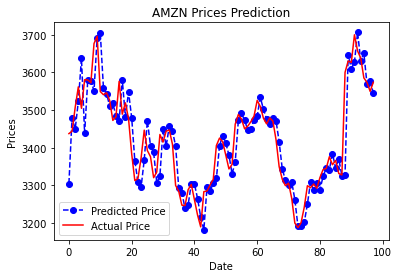

In [107]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

## The arima model is likely too slow to implement onto the dashboard, so I will build an xgboost model instead. I will make two general models, one that predicts next day close and one that predicts next 4 hour close.

In [108]:
prediction_df = build_xgboost_df('AMZN')
prediction_df.tail()

Close_1day  Close_2day  Close_3day  High_1day  High_2day  High_3day  \
130     3230.11     3265.16     3259.05    3260.36    3295.73    3279.82   
131     3265.16     3259.05     3244.99    3295.73    3279.82    3257.95   
132     3259.05     3244.99     3203.08    3279.82    3257.95    3256.30   
133     3244.99     3203.08     3247.68    3257.95    3256.30    3259.68   
134     3203.08     3247.68     3231.80    3256.30    3259.68    3234.58   

     Cot_1day  Cot_2day  Cot_3day   Vol_1day   Vol_2day   Vol_3day    value  \
130  -0.00795  -0.00288  -0.00233  2344894.0  2364794.0  3132345.0  3223.07   
131  -0.00288  -0.00233   0.00917  2364794.0  3132345.0  2304524.0  3230.11   
132  -0.00233   0.00917  -0.01444  3132345.0  2304524.0  3838494.0  3265.16   
133   0.00917  -0.01444   0.00101  2304524.0  3838494.0  2549587.0  3259.05   
134  -0.01444   0.00101   0.01152  3838494.0  2549587.0  2588052.0  3244.99   

          Date  News_Sentiment_1day  
130 2021-05-28             0.195417  
131 2021-05-27             0.288600  
132 2021-05-26             0.237599  
133 2021-05-25             0.132458  
134 2021-05-24             0.160100

In [109]:
test_data, train_data = prediction_df[0:int(len(prediction_df)*.07)], \
                            prediction_df[int(len(prediction_df)*.07):]

#### - Plot data in the following format:
- 3 distinct lines separated by color
- plot y_train
- plot y_test
- plot y_preds

In [110]:
X_test = test_data.drop(columns = ['Date', 'value'])
#X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)
y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])

y_test = test_data.value

In [111]:
xg = GradientBoostingRegressor()
xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))

In [112]:
xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1
        
pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1

In [113]:
xg_df, xg, pred_df, apple_mae = build_general_model_daily_prediction_df('AMZN')

In [114]:
float(mean_absolute_error(y_test, y_pred))

42.74492496322551

In [115]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True)
fig.show()

In [116]:
tomorrow_tsla_close_price = make_tomorrow_pred('AMZN', prediction_df, xg)

In [117]:
tomorrow_tsla_close_price

array([3464.83995269])

In [118]:
tomorrow_tsla_close_price

array([3464.83995269])

In [119]:
a = vader_sentiment_analysis(apikey, 'AMZN', 20)
    
b = np.mean(trim_news_dates(datetime.today().strftime('%Y-%m-%d'), a).CompoundAvg)

In [120]:
trim_news_dates('2021-11-22' ,a)

Empty DataFrame
Columns: [Date, Title, Text, CompoundScoreTitle, PositiveScoreTitle, NegativeScoreTitle, CompoundScoreText, NeutralScoreTitle, NeutralScoreText, textLeans, titleLeans, PositiveScoreText, NegativeScoreText, CompoundAvg, Symbol, weekday, time]
Index: []

In [121]:
b

0.14548125

#### Feature Importances

In [122]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AAPL')

In [123]:
importance_df = pd.DataFrame(xg.feature_importances_, columns=['importance'])
importance_df['feature_name'] = prediction_df.drop(columns=['Date', 'value']).columns

In [124]:
importance_df.sort_values('importance', ascending=False, ignore_index=True)

importance         feature_name
0     0.222016           Close_1day
1     0.209297           Close_3day
2     0.181049           Close_2day
3     0.180638            High_2day
4     0.152719            High_3day
5     0.034641            High_1day
6     0.004279             Cot_3day
7     0.003802             Vol_3day
8     0.003307             Cot_1day
9     0.002557             Cot_2day
10    0.002442             Vol_2day
11    0.001695             Vol_1day
12    0.001557  News_Sentiment_1day

<AxesSubplot:>

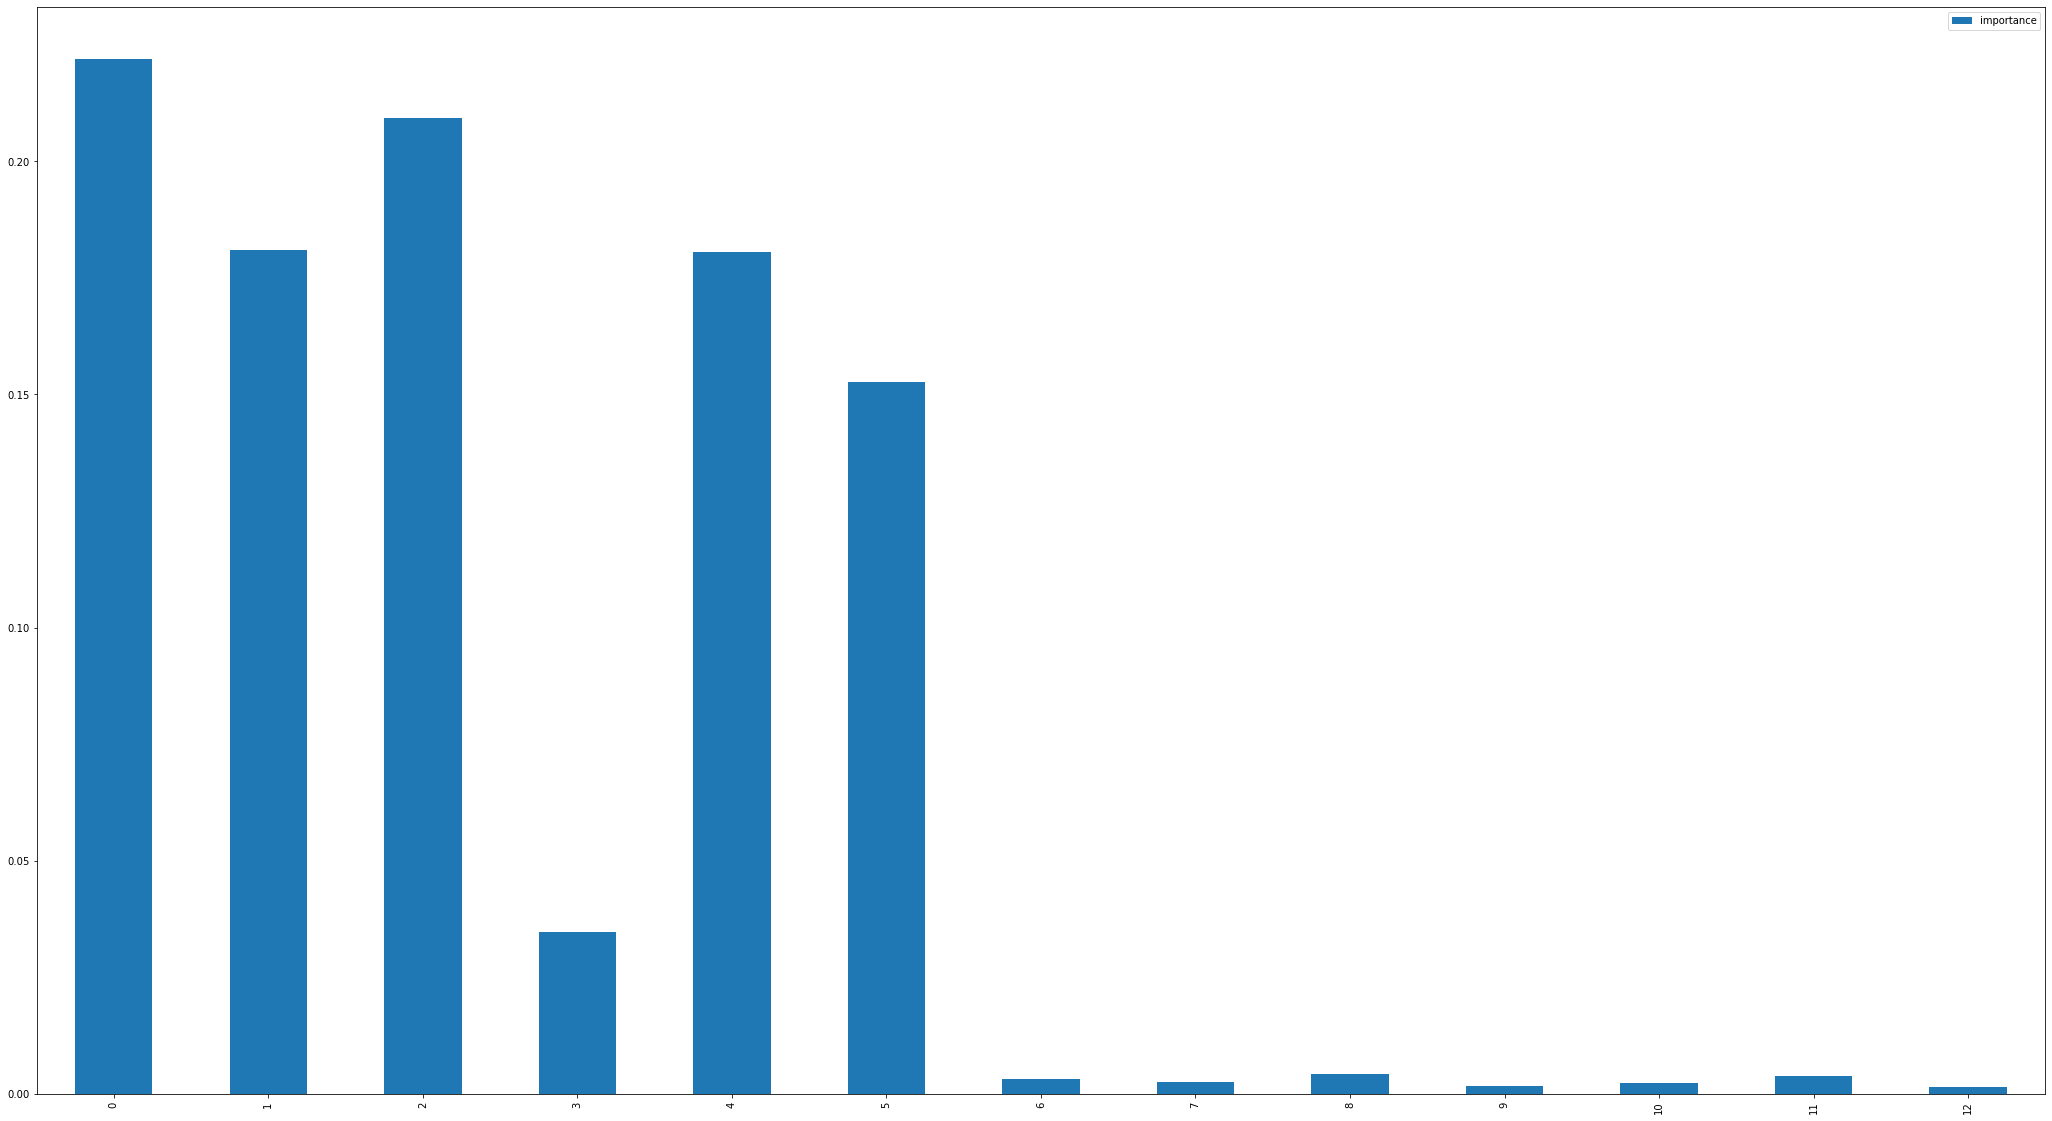

In [125]:
importance_df.plot(kind='bar')

In [126]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'NEXT Day Prediction: '+str(make_tomorrow_pred('MSFT', prediction_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

#### Unsurprisingly, the closing price of the previous day is the biggest predictor. Going forward, I am going to investigate how much public news sentiment can help this model.

In [127]:
df = vader_sentiment_analysis(apikey, 'MSFT')

In [128]:
df.head(3)

Date                                             Title  \
0 2021-12-03 05:30:45  Cloud Segment To Drive Microsoft's Stock Growth?   
1 2021-12-03 05:17:22       A Deep Dive Into The Semiconductor Industry   
2 2021-12-03 03:43:59       Zoom And Gloom: Microsoft Drops A Bombshell   

                                                Text  CompoundScoreTitle  \
0  Microsoft's stock (NASDAQ: MSFT) has increased...              0.3818   
1  Semiconductors are an important and fast growi...              0.0000   
2  Microsoft has released a standalone version of...             -0.5574   

   PositiveScoreTitle  NegativeScoreTitle  CompoundScoreText  \
0               0.302               0.000             0.2732   
1               0.000               0.000             0.1531   
2               0.000               0.419             0.6124   

   NeutralScoreTitle  NeutralScoreText textLeans titleLeans  \
0              0.698             0.940  Positive   Positive   
1              1.000             0.733  Positive    Neutral   
2              0.581             0.643  Positive   Negative   

   PositiveScoreText  NegativeScoreText  CompoundAvg Symbol  weekday      time  
0              0.060              0.000      0.32750   MSFT        4  05:30:45  
1              0.172              0.095      0.07655   MSFT        4  05:17:22  
2              0.238              0.119      0.02750   MSFT        4  03:43:59

#### Now, I need to implement sentiment scores into already developed time series dataframe that I have developed. Each day should receive a general sentiment. What I will do is if add three columns one_day news sentiment, two_day news sentiment, and three_day news sentiment. These columns will contain the compund average score of all the compound average scores of the news titles/artiles for the day.

In [129]:
trimmed_df = trim_news_dates('2021-11-22', df)

In [130]:
np.mean(trimmed_df.CompoundAvg)

0.401975

#### The Plan:
- Add a clause into the build build_general_model_daily_prediction_df(stock) that will add the mean Compound AvG score for the prior stock day.

In [131]:
prediction_df = build_xgboost_df('AAPL')


In [132]:
prediction_df['News_Sentiment_1day'] = None

In [133]:
df = vader_sentiment_analysis(apikey, 'AAPL')

In [134]:
determine_date_range(df)

(Timestamp('2020-10-26 05:00:00'), Timestamp('2021-12-03 05:17:22'))

In [135]:
prediction_df.News_Sentiment_1day = prediction_df.Date.apply(
    lambda dat: np.mean(trim_news_dates(str(dat), df).CompoundAvg))

In [136]:
prediction_df.tail()

Close_1day  Close_2day  Close_3day   High_1day   High_2day   High_3day  \
130  125.279999  126.849998  126.900002  127.639999  127.389999  128.320007   
131  126.849998  126.900002  127.099998  127.389999  128.320007  127.940002   
132  126.900002  127.099998  125.430000  128.320007  127.940002  128.000000   
133  127.099998  125.430000  127.309998  127.940002  128.000000  127.720001   
134  125.430000  127.309998  124.690002  128.000000  127.720001  124.919998   

     Cot_1day  Cot_2day  Cot_3day    Vol_1day    Vol_2day    Vol_3day  \
130  -0.00917  -0.00087  -0.00720  94625600.0  56575900.0  72009500.0   
131  -0.00087  -0.00720   0.00865  56575900.0  72009500.0  63092900.0   
132  -0.00720   0.00865  -0.01870  72009500.0  63092900.0  79295400.0   
133   0.00865  -0.01870   0.01661  63092900.0  79295400.0  76857100.0   
134  -0.01870   0.01661   0.01242  79295400.0  76857100.0  92612000.0   

          value       Date  News_Sentiment_1day  
130  124.610001 2021-05-28             0.085120  
131  125.279999 2021-05-27             0.388271  
132  126.849998 2021-05-26             0.170662  
133  126.900002 2021-05-25             0.068586  
134  127.099998 2021-05-24            -0.120000

#### Now, I can make additional predictions.

In [137]:
test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                        prediction_df[int(len(prediction_df)*.1):]

X_test = test_data.drop(columns = ['Date', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])
y_test = test_data.value

xg = GradientBoostingRegressor()
xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
        count += 1

In [138]:
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1

In [139]:
xgboost_prediction_df

value data_category       Date
0    163.760000          test 2021-12-02
1    164.770000          test 2021-12-01
2    165.300000          test 2021-11-30
3    160.240000          test 2021-11-29
4    156.810000          test 2021-11-26
..          ...           ...        ...
143  154.246920          pred 2021-11-19
144  151.949215          pred 2021-11-18
145  150.203832          pred 2021-11-17
146  151.082120          pred 2021-11-16
147  150.995757          pred 2021-11-15

[148 rows x 3 columns]

In [140]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True,
             title = 'NEXT Day Prediction: '+str(make_tomorrow_pred('AAPL', prediction_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [141]:
mae

8.363657757430055

In [142]:
apple_mae

64.99953928934751

#### Now, that I have added news sentiment I will compare models and explore results. I want to investigate if the news sentiment is helping the model.

In [143]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AAPL')

In [144]:
mae

7.8925867950568565

In [145]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'WITH NEWS SENTIMENT NEXT Day Prediction For AAPL: '+str(make_tomorrow_pred('ACB', pred_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [146]:
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
             title = 'WITHOUT NEWS SENTIMENT NEXT Day Prediction For AAPL: '+str(make_tomorrow_pred('AAPL', pred_df, xg)) \
                                                +" +/- "+str(mae))
fig.show()

In [147]:
amzn_df = build_time_series_df('AAPL')
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))


Testing Mean Absolute Error is 2.274840503409096


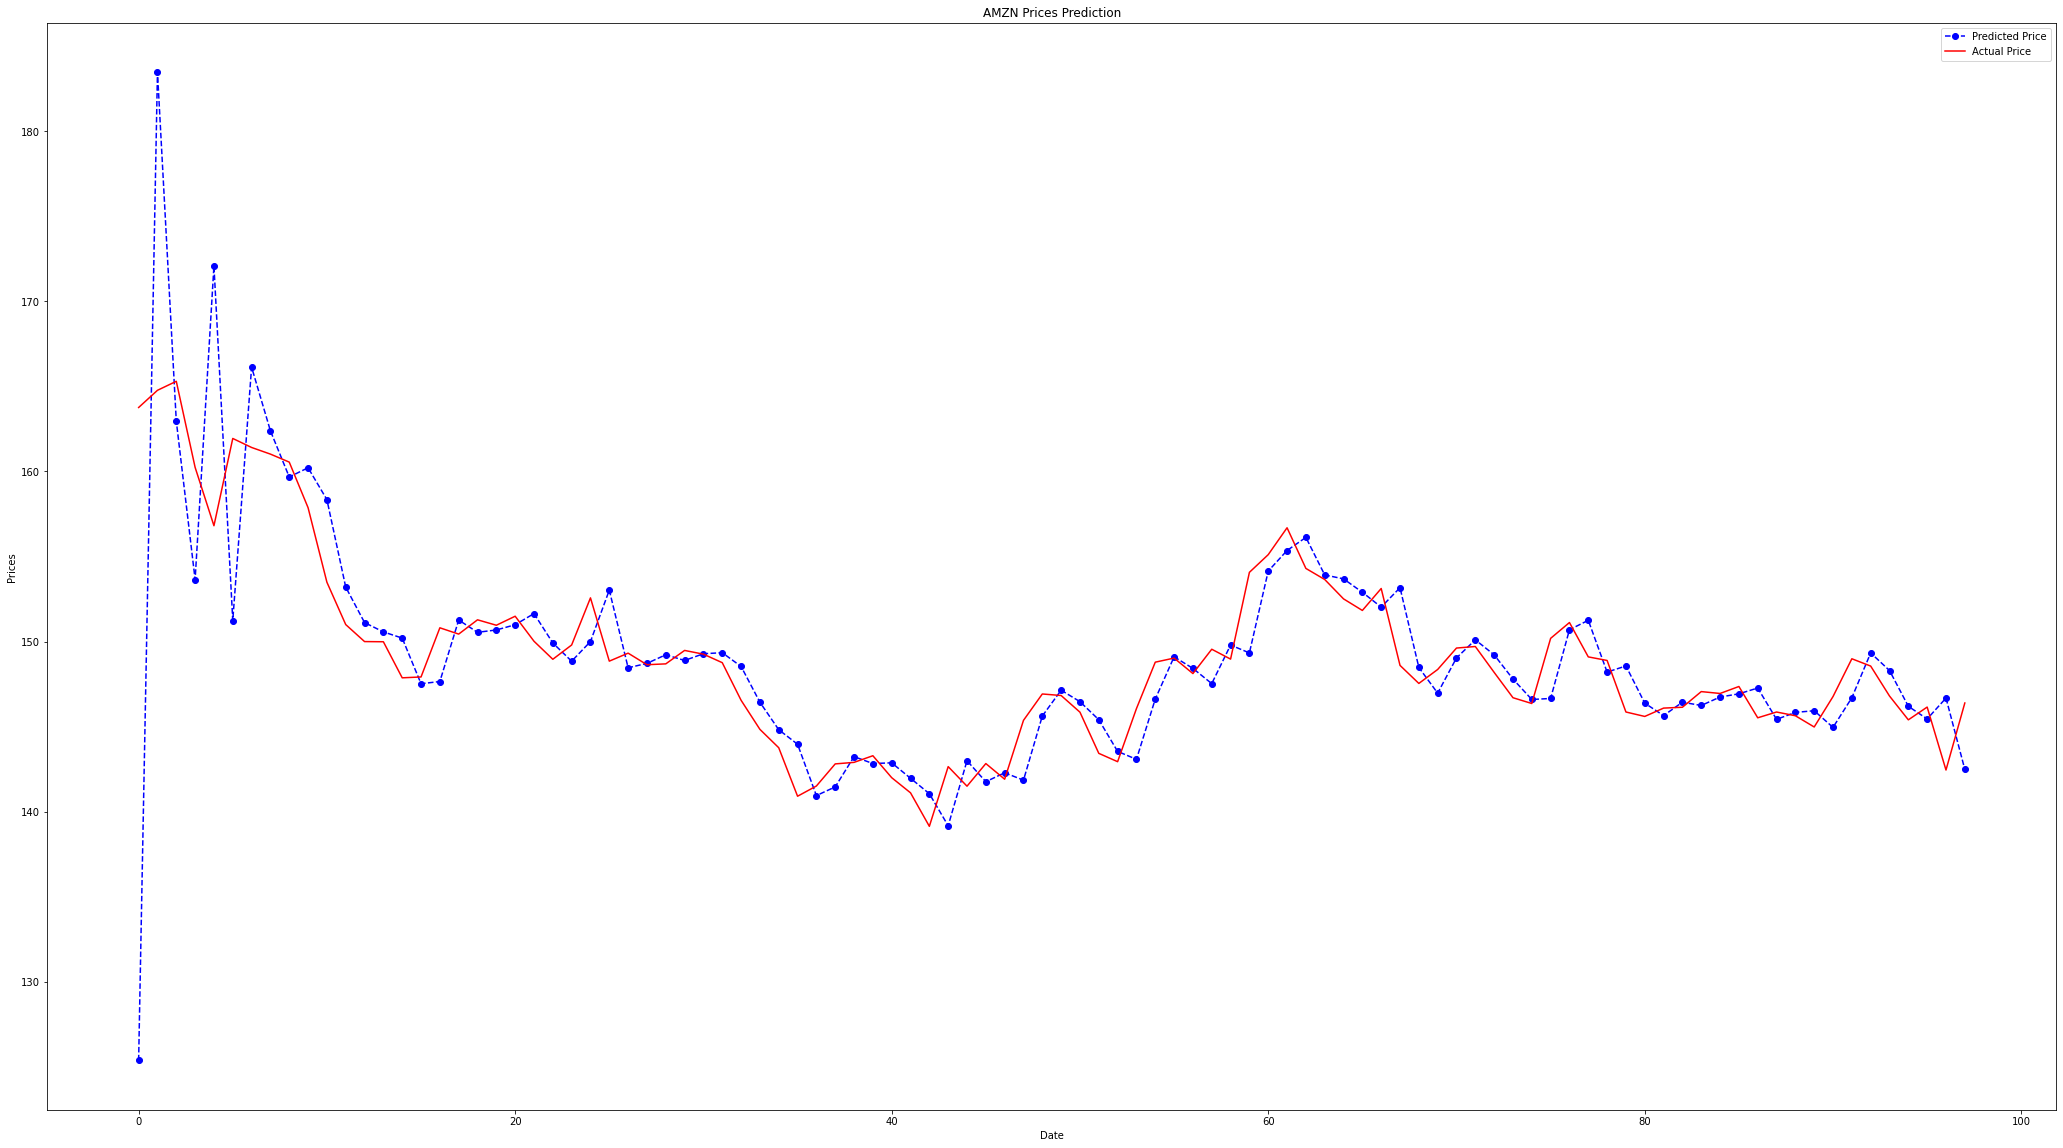

In [148]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

#### Now, I will develop an XGBOOST model the same way except this time it will predict the next close price in a 1 hour window.

In [149]:
hourly_stock = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")

In [150]:
hourly_stock[0]['date']

'2021-12-02 16:00:00'

In [151]:
hourly_df = pd.DataFrame(columns = ['Time', 'Close', 'High', 'Volume', 'Low'])
opens = []
times = []
closes = []
highs = []
volumes = []
lows = []
for hour in hourly_stock:
    times.append(hour['date'])
    opens.append(hour['open'])
    closes.append(hour['close'])
    highs.append(hour['high'])
    volumes.append(hour['volume'])
    lows.append(hour['low'])

hourly_df.Time = times
hourly_df.Close = closes
hourly_df.High = highs
hourly_df.Volume = volumes
hourly_df.Low = lows

In [152]:
hourly_df.head()

Time     Close    High    Volume       Low
0  2021-12-02 16:00:00  163.8500  164.18   2882360  163.4400
1  2021-12-02 15:00:00  163.7900  164.20  16174386  163.1300
2  2021-12-02 14:00:00  163.4200  163.98  12166493  162.9300
3  2021-12-02 13:00:00  163.4198  163.54  11178841  162.5400
4  2021-12-02 12:00:00  163.0900  163.70  15807714  162.0801

#### Now, I just need to remake the xg_df

In [153]:
pred_hourly_df = build_xgboost_hourly_df('AAPL')

In [154]:
pred_hourly_df.head(1)

Close_1hour  Close_2hour  Close_3hour  High_1hour  High_2hour  High_3hour  \
0       163.79       163.42     163.4198       164.2      163.98      163.54   

   Low_1hour  Low_2hour  Low_3hour  Vol_1hour  Vol_2hour  Vol_3hour   value  \
0     163.13     162.93     162.54   16174386   12166493   11178841  163.85   

                  Time  
0  2021-12-02 16:00:00

#### Now, I can make prediction and evaluate the model

In [155]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AAPL')

In [156]:
prediction_hourly_df

Close_1hour  Close_2hour  Close_3hour  High_1hour  High_2hour  \
0       163.7900     163.4200     163.4198  164.200000  163.980000   
1       163.4200     163.4198     163.0900  163.980000  163.540000   
2       163.4198     163.0900     162.3750  163.540000  163.700000   
3       163.0900     162.3750     160.4901  163.700000  162.480000   
4       162.3750     160.4901     164.6000  162.480000  161.370000   
..           ...          ...          ...         ...         ...   
268     143.0101     143.2850     143.2000  143.490000  143.960000   
269     143.2850     143.2000     143.2800  143.960000  143.307194   
270     143.2000     143.2800     143.5400  143.307194  143.840000   
271     143.2800     143.5400     143.9433  143.840000  144.000000   
272     143.5400     143.9433     144.0450  144.000000  144.170000   

     High_3hour  Low_1hour  Low_2hour  Low_3hour  Vol_1hour  Vol_2hour  \
0    163.540000   163.1300   162.9300   162.5400   16174386   12166493   
1    163.700000   162.9300   162.5400   162.0801   12166493   11178841   
2    162.480000   162.5400   162.0801   160.2100   11178841   15807714   
3    161.370000   162.0801   160.2100   159.0300   15807714   18452937   
4    165.280000   160.2100   159.0300   164.0200   18452937   21910226   
..          ...        ...        ...        ...        ...        ...   
268  143.307194   142.9500   143.0700   142.9800    6439722    9438279   
269  143.840000   143.0700   142.9800   143.0000    9438279    1482281   
270  144.000000   142.9800   143.0000   143.4250    1482281    9660913   
271  144.170000   143.0000   143.4250   143.9100    9660913    5440328   
272  144.140000   143.4250   143.9100   143.6250    5440328    5011564   

     Vol_3hour     value                 Time  
0     11178841  163.8500  2021-12-02 16:00:00  
1     15807714  163.7900  2021-12-02 15:00:00  
2     18452937  163.4200  2021-12-02 14:00:00  
3     21910226  163.4198  2021-12-02 13:00:00  
4      4200867  163.0900  2021-12-02 12:00:00  
..         ...       ...                  ...  
268    1482281  142.9700  2021-10-08 12:00:00  
269    9660913  143.0101  2021-10-08 11:00:00  
270    5440328  143.2850  2021-10-08 10:00:00  
271    5011564  143.2000  2021-10-07 16:00:00  
272    5295528  143.2800  2021-10-07 15:00:00  

[273 rows x 14 columns]

In [157]:
xg_hourly_df

value data_category                 Time
0    163.850000          test  2021-12-02 16:00:00
1    163.790000          test  2021-12-02 15:00:00
2    163.420000          test  2021-12-02 14:00:00
3    163.419800          test  2021-12-02 13:00:00
4    163.090000          test  2021-12-02 12:00:00
..          ...           ...                  ...
274  162.891703          pred  2021-12-02 15:00:00
275  162.936804          pred  2021-12-02 14:00:00
276  163.646985          pred  2021-12-02 13:00:00
277  163.396585          pred  2021-12-02 12:00:00
278  161.784137          pred  2021-12-02 11:00:00

[279 rows x 3 columns]

In [158]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True
             )
fig.show()

#### Lastly, I need to predict the next hour close price.

In [159]:
hourly_stock = fmpsdk.historical_chart(apikey, 'AAPL', "1hour")

In [160]:
hourly_stock[0]

{'date': '2021-12-02 16:00:00',
 'open': 163.76,
 'low': 163.44,
 'high': 164.18,
 'close': 163.85,
 'volume': 2882360}

In [161]:
apple_next_hour_price = make_next_hour_pred('AAPL', prediction_hourly_df, xg_hourly_model)

In [162]:
apple_next_hour_price

array([161.17325804])

In [163]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AAPL, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AAPL', prediction_hourly_df, xg_hourly_model)) + '+/- '+str(mae)
             )
fig.show()

## Optimization
 - Up to this point the XGBOOST models are vanilla. I suspect optimization will not be useful because of the computation added to an already strained system.
 - However, I want to see how much improvement I can get for both the daily and general models.
 - To test this I will make two vanilla models predicting AMZN and then two optimized models predicting AMZN.

### Hourly Vanilla

In [164]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AMZN')
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_hourly_df, xg_hourly_model)) + '+/- '+str(mae)
             )
fig.show()

### Daily Vanilla

In [165]:
xg_df, xg, pred_df, mae = build_general_model_daily_prediction_df('AMZN')
fig = px.line(xg_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Close Prediction: '+ \
              str(make_tomorrow_pred('AMZN', pred_df, xg)) + '+/- '+str(mae)
             )
fig.show()


### Hourly Optimized

In [166]:
prediction_df = build_xgboost_hourly_df('AMZN')

test_data, train_data = prediction_df[0:int(len(prediction_df)*.025)], \
                        prediction_df[int(len(prediction_df)*.025):]

X_test = test_data.drop(columns = ['Time', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Time', 'value'])
y_test = test_data.value

parameters = {
    'max_depth': range (0, 15, 1),
    'n_estimators': range (1, 10, 1),
    'learning_rate':  np.linspace(.1, 1, 10)   
}



xg = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
xg = GradientBoostingRegressor(**grid_search.best_params_)
xg.fit(X_train, y_train)
#xg.fit(X_train, y_train)
y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Time'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Time = prediction_df.Time



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = list(xgboost_prediction_df.iloc[:len(y_test)].Time)
count = 0
i = 0
for date in xgboost_prediction_df.Time:
    if date is np.nan:
        xgboost_prediction_df.Time[count] = pred_dates[i]
        i += 1
    count += 1

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
{'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 9}


In [167]:
fig = px.line(xgboost_prediction_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_df, xg)) + '+/- '+str(mae)
             )
fig.show()

### Daily Optimized

In [168]:
prediction_df = build_xgboost_df('AMZN')

test_data, train_data = prediction_df[0:int(len(prediction_df)*.1)], \
                        prediction_df[int(len(prediction_df)*.1):]

X_test = test_data.drop(columns = ['Date', 'value'])

y_train = train_data.value
X_train = train_data.drop(columns = ['Date', 'value'])
y_test = test_data.value

parameters = {
    'max_depth': range (0, 15, 1),
    'n_estimators': range (1, 10, 1),
    'learning_rate':  np.linspace(.1, 1, 10)   
}



xg = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
xg = GradientBoostingRegressor(**grid_search.best_params_)
xg.fit(X_train, y_train)

y_pred = pd.Series(xg.predict(X_test))
mae = np.sqrt(mean_squared_error(y_test, y_pred))

xgboost_prediction_df = pd.DataFrame(columns = ['value', 'data_category', 'Date'])
combined_list = pd.concat([y_test, y_train, y_pred])
combined_list.reset_index(drop = True, inplace = True)

xgboost_prediction_df.value = combined_list
xgboost_prediction_df.Date = prediction_df.Date



test_cutoff = len(y_test)
pred_cutoff = len(y_test) + len(y_train)
counter = 0
for i in range(len(combined_list)):
    if (counter > test_cutoff)&(counter < pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'train'
    elif (counter <= test_cutoff):
        xgboost_prediction_df.data_category[i] = 'test'
    elif (counter >= pred_cutoff):
        xgboost_prediction_df.data_category[i] = 'pred'
    counter += 1

pred_dates = xgboost_prediction_df.iloc[:len(y_test)].Date
count = 0
i = 0
for date in xgboost_prediction_df.Date:
    if str(date)[0] == 'N':
        xgboost_prediction_df.Date[count] = pred_dates[i]
        i += 1
    count += 1


#return xgboost_prediction_df, xg, prediction_df, mae

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
{'learning_rate': 0.30000000000000004, 'max_depth': 2, 'n_estimators': 7}


In [169]:
fig = px.line(xgboost_prediction_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Close Prediction: '+ \
              str(make_tomorrow_pred('AMZN', prediction_df, xg)) + '+/- '+str(mae)
             )
fig.show()

### Optimization Analysis
- Vanilla Daily
    - MAE = 76.8
- Vanilla Hourly
    - MAE = .6
- Optimized Daily
    - MAE = 71.5
- Optimized Hourly
    - MAE = 38.7
    
    
#### Based on these results I am concluding that is acceptable to leave the implemented algorithms in their vanilla state.

## Volume, Insider Trading, and Price Inspection

#### Because stock price is determined by supply and demand, I am curious to see how much large sell offs affect the price. To investigate this I am going to look at insider trades, share volume and stock price. 
- First, I will see how volume and price look together

In [170]:
amzn_stock_data = fmpsdk.historical_price_full(apikey, 'AMZN')

In [171]:
prices = []
volumes = []
dates = []
for json in amzn_stock_data['historical']:
    prices.append(json['open'])
    volumes.append(json['volume'])
    dates.append(json['date']) 

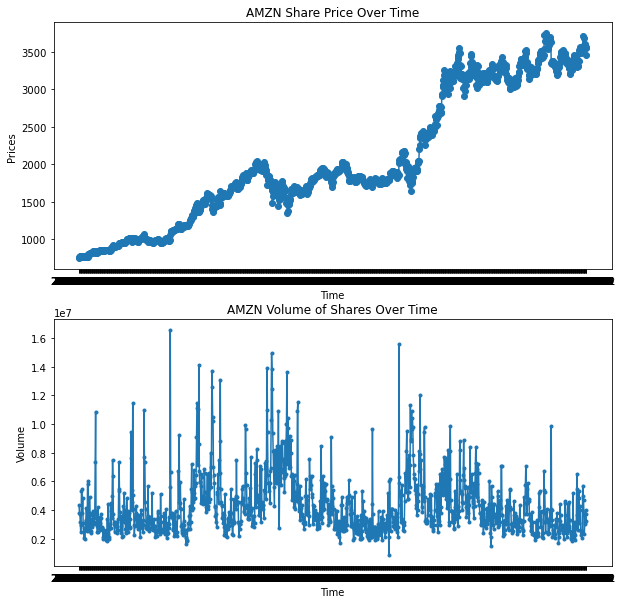

In [172]:
dates.reverse()
prices.reverse()
volumes.reverse()
x1 = dates
y1 = prices

x2 = dates
y2 = volumes


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ax1.set_title('AMZN Share Price Over Time')
ax1.plot(x1, y1, 'o-')
ax1.set_ylabel('Prices')
ax1.set_xlabel('Time')

ax2.set_title('AMZN Volume of Shares Over Time')
ax2.plot(x2, y2, '.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')

plt.show()



In [173]:
from scipy.stats import pearsonr

In [174]:
correlation, p_value = pearsonr(prices, volumes)
print('Correlation:', '        Correlation P-Value:')
print(correlation, p_value)

Correlation:         Correlation P-Value:
-0.04695575262355186 0.09597199097472092


#### There does appear to be a relationship between the two. The other consideration to make is stock splits, which is when a company splits their current stock amount to make more. The negative correlation adn pval above .05 threshold confirm there is a relationship. This would increase volume but not necessarily affect price. Now, I will see how insider trades might affect these two.

In [175]:
amzn_inside_trade = fmpsdk.insider_trading(apikey, 'AMZN', limit = 1000)

In [176]:
shares_sold = []
date = []

for json in amzn_inside_trade:
    if json['transactionType'] == 'S-Sale':
        shares_sold.append(json['securitiesTransacted'])
        date.append(json['transactionDate'])

shares_sold.reverse()
date.reverse()

In [177]:
idx = 0
for date_ in date:
    date[idx] = date_[5:]
    idx += 1

Text(0.5, 0, 'Date')

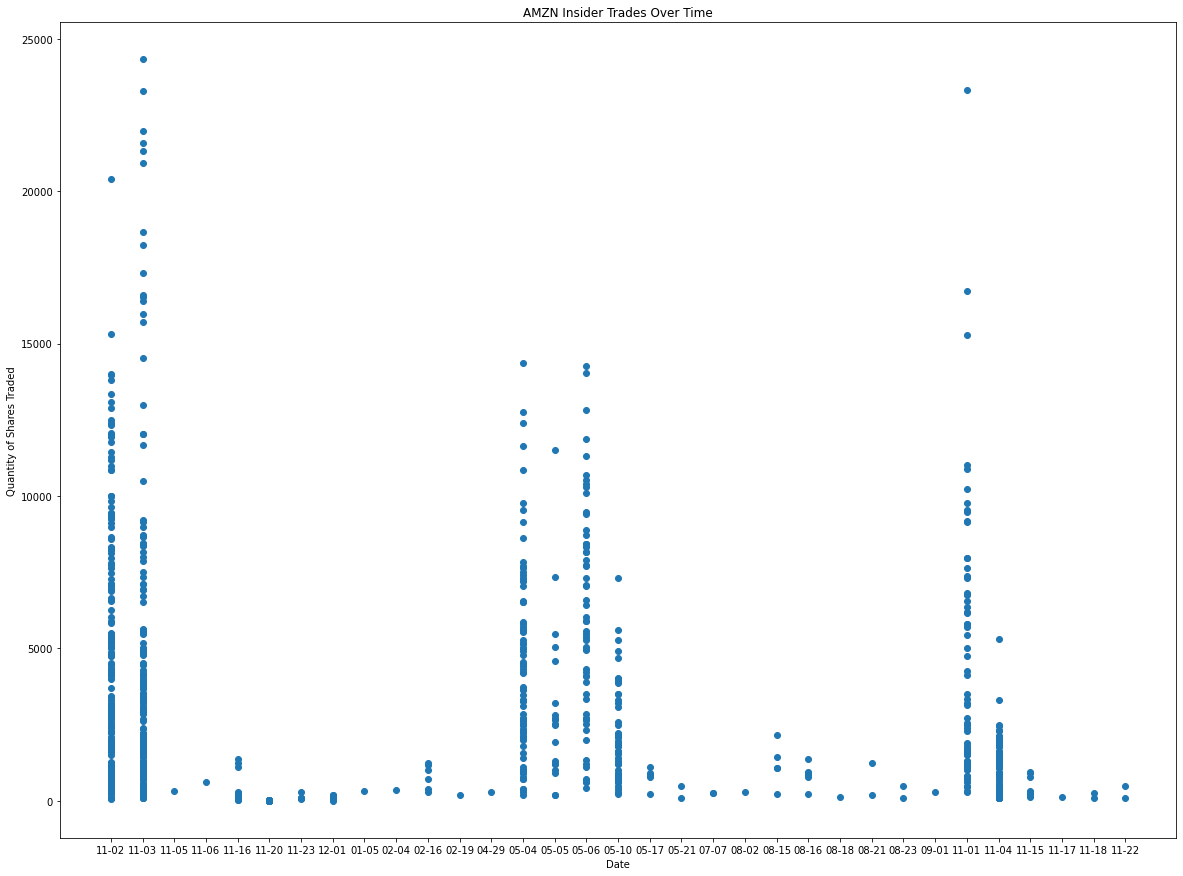

In [178]:
x1 = date
y1 = shares_sold




fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

ax1.set_title('AMZN Insider Trades Over Time')
ax1.scatter(x1, y1)
#ax1.boxplot(x1, y1)
ax1.set_ylabel('Quantity of Shares Traded')
ax1.set_xlabel('Date')

#### There are clearly moments when the insider trading activity is high. This is very, very interesting. In order to see if this affects price/volume I need to join the data based on date. I will do this in a pandas dataframe where the index will be date and go day by day. Because the api call to get insider trades has the limit parameter, I will define the scope of the date from that date range.

In [179]:
amzn_inside_trade = fmpsdk.insider_trading(apikey, 'AMZN', limit = 750)

In [180]:
insider_df = pd.DataFrame(columns = ['SharesTransacted', 'Date', 'Volume', 'Open_Price'])

shares_sold = []
date = []

for json in amzn_inside_trade:
    if json['transactionType'] == 'S-Sale':
        shares_sold.append(json['securitiesTransacted'])
        date.append(json['transactionDate'])
insider_df.Date = date
insider_df.SharesTransacted = shares_sold

In [181]:
insider_df.head()

SharesTransacted        Date Volume Open_Price
0             492.0  2021-11-22    NaN        NaN
1             105.0  2021-11-22    NaN        NaN
2              86.0  2021-11-18    NaN        NaN
3             271.0  2021-11-18    NaN        NaN
4             139.0  2021-11-17    NaN        NaN

#### There are multiple shares transacted in a single day. I need to add these values so that there is just one day per row.

In [182]:
insider_df.SharesTransacted = insider_df.Date.apply(lambda date:
                                np.sum(insider_df.loc[insider_df.Date == date].SharesTransacted))

#### Now, I need to drop duplicate dates

In [183]:
insider_df.Date.value_counts()

2021-11-04    92
2021-11-03    84
2021-05-04    80
2021-11-01    62
2021-05-06    61
2021-05-10    57
2021-11-02    44
2020-11-20    30
2020-12-01    19
2021-05-05    19
2020-11-16    13
2021-11-15    11
2021-02-16     6
2020-11-23     6
2021-08-16     6
2021-05-17     5
2021-08-15     5
2021-11-22     2
2021-05-21     2
2021-11-18     2
2021-08-21     2
2021-08-23     2
2021-07-07     2
2021-08-02     1
2021-08-18     1
2021-04-29     1
2021-02-19     1
2021-02-04     1
2021-01-05     1
2021-09-01     1
2021-11-16     1
2021-11-17     1
Name: Date, dtype: int64

In [184]:
insider_df.drop_duplicates(inplace=True)

In [185]:
insider_df.reset_index(drop=True, inplace=True)

In [186]:
insider_df.head(5)

SharesTransacted        Date Volume Open_Price
0             597.0  2021-11-22    NaN        NaN
1             357.0  2021-11-18    NaN        NaN
2             139.0  2021-11-17    NaN        NaN
3              34.0  2021-11-16    NaN        NaN
4            4431.0  2021-11-15    NaN        NaN

#### Now I need to fill in the missing dates

In [187]:
insider_df.Date = insider_df.Date.apply(lambda date: pd.to_datetime(date))
current_dates = list(insider_df.Date)

In [188]:
insider_df.Date.min()

Timestamp('2020-11-16 00:00:00')

In [189]:
insider_df.Date.max()

Timestamp('2021-11-22 00:00:00')

In [190]:
r = pd.date_range(start=insider_df.Date.min(), end=insider_df.Date.max())

In [191]:
insider_final_df = pd.DataFrame(columns = ['Date', 'Shares_Sold', 'Volume', 'Price'])

In [192]:
insider_final_df['Date'] = r

In [193]:
insider_final_df.Date = insider_final_df.Date.apply(lambda date: pd.to_datetime(date))

In [194]:
insider_final_df.Shares_Sold = insider_final_df.Date.apply(lambda date:
                                int(insider_df.loc[insider_df.Date == date].SharesTransacted)
                                if date in current_dates
                                else(0))

In [195]:
insider_final_df.head()

Date  Shares_Sold Volume Price
0 2020-11-16         5207    NaN   NaN
1 2020-11-17            0    NaN   NaN
2 2020-11-18            0    NaN   NaN
3 2020-11-19            0    NaN   NaN
4 2020-11-20          172    NaN   NaN

#### Now, I need to add volume and price

In [196]:
from_ = insider_final_df.Date.min()
to_ = insider_final_df.Date.max()
amzn_stock_data = fmpsdk.historical_price_full(apikey, 'AMZN',from_date = from_,
                                              to_date = to_)

In [197]:
prices = []
volumes = []
dates = []
vol_price_df = pd.DataFrame(columns = ['price', 'date', 'volume'])
for json in amzn_stock_data['historical']:
    prices.append(json['open'])
    volumes.append(json['volume'])
    dates.append(json['date']) 
vol_price_df.price = prices
vol_price_df.date = dates
vol_price_df.volume = volumes

In [198]:
vol_price_df.head()

price        date     volume
0  3676.3767  2021-11-22  4704715.0
1  3712.6900  2021-11-19  4946203.0
2  3566.3500  2021-11-18  5703538.0
3  3564.7200  2021-11-17  2560270.0
4  3539.0000  2021-11-16  2060478.0

In [199]:
type(vol_price_df.date[0])

str

In [200]:
vol_price_df.date = vol_price_df.date.apply(lambda date:pd.to_datetime(date))

In [201]:
stock_dates = list(vol_price_df.date)

In [202]:
insider_final_df.Volume = insider_final_df.Date.apply(lambda date:
                                int(vol_price_df.loc[vol_price_df.date == date].volume)
                                if date in stock_dates else(np.nan))
insider_final_df.Price = insider_final_df.Date.apply(lambda date:
                                int(vol_price_df.loc[vol_price_df.date == date].price)
                                if date in stock_dates else(np.nan))

In [203]:
insider_final_df.head(30)

Date  Shares_Sold     Volume   Price
0  2020-11-16         5207  3808700.0  3093.0
1  2020-11-17            0  3444700.0  3183.0
2  2020-11-18            0  2916800.0  3134.0
3  2020-11-19            0  3010300.0  3105.0
4  2020-11-20          172  3374400.0  3117.0
5  2020-11-21            0        NaN     NaN
6  2020-11-22            0        NaN     NaN
7  2020-11-23          750  4708900.0  3116.0
8  2020-11-24            0  3602100.0  3100.0
9  2020-11-25            0  3790400.0  3141.0
10 2020-11-26            0        NaN     NaN
11 2020-11-27            0  2392900.0  3211.0
12 2020-11-28            0        NaN     NaN
13 2020-11-29            0        NaN     NaN
14 2020-11-30            0  4063900.0  3208.0
15 2020-12-01         2000  4544400.0  3188.0
16 2020-12-02            0  3129300.0  3221.0
17 2020-12-03            0  2892000.0  3205.0
18 2020-12-04            0  2913600.0  3198.0
19 2020-12-05            0        NaN     NaN
20 2020-12-06            0        NaN     NaN
21 2020-12-07            0  2751300.0  3156.0
22 2020-12-08            0  3286300.0  3158.0
23 2020-12-09            0  4100800.0  3167.0
24 2020-12-10            0  3030200.0  3088.0
25 2020-12-11            0  3064700.0  3096.0
26 2020-12-12            0        NaN     NaN
27 2020-12-13            0        NaN     NaN
28 2020-12-14            0  4155800.0  3143.0
29 2020-12-15            0  3323700.0  3181.0

In [204]:
insider_final_df.dropna(inplace=True)
insider_final_df.reset_index(drop=True, inplace=True)

In [205]:
insider_final_df

Date  Shares_Sold     Volume   Price
0   2020-11-16         5207  3808700.0  3093.0
1   2020-11-17            0  3444700.0  3183.0
2   2020-11-18            0  2916800.0  3134.0
3   2020-11-19            0  3010300.0  3105.0
4   2020-11-20          172  3374400.0  3117.0
..         ...          ...        ...     ...
252 2021-11-16           34  2060478.0  3539.0
253 2021-11-17          139  2560270.0  3564.0
254 2021-11-18          357  5703538.0  3566.0
255 2021-11-19            0  4946203.0  3712.0
256 2021-11-22          597  4704715.0  3676.0

[257 rows x 4 columns]

#### Now, I will compare them like I did above.

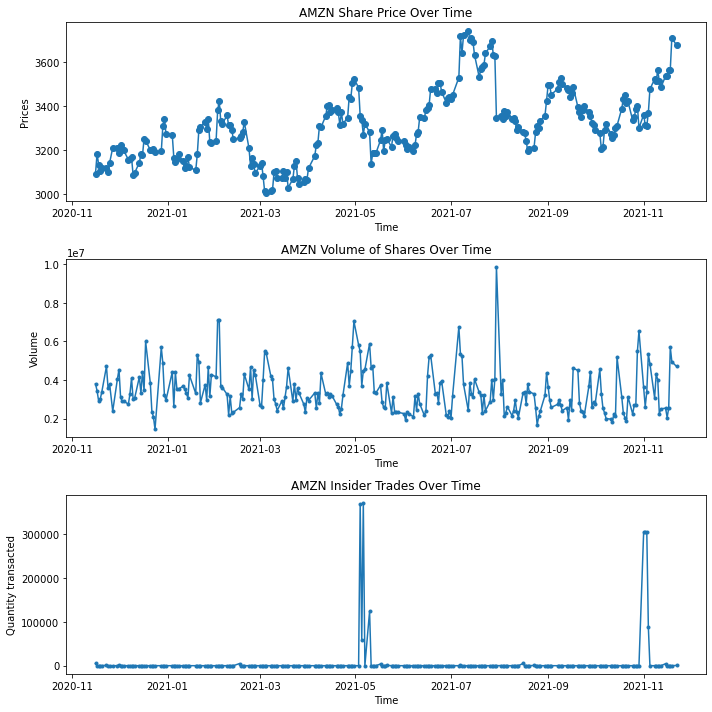

In [206]:
x = list(insider_final_df.Date)

y1 = list(insider_final_df.Price)

y2 = list(insider_final_df.Volume)

y3 = list(insider_final_df.Shares_Sold)




fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

ax1.set_title('AMZN Share Price Over Time')
ax1.plot(x, y1, 'o-')
ax1.set_ylabel('Prices')
ax1.set_xlabel('Time')

ax2.set_title('AMZN Volume of Shares Over Time')
ax2.plot(x, y2, '.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')

ax3.set_title('AMZN Insider Trades Over Time')
ax3.plot(x, y3, '.-')
ax3.set_xlabel('Time')
ax3.set_ylabel('Quantity transacted')
plt.tight_layout()
plt.show()

#### Very, very, very interesting. It appears that in the 2021-05 time there was a large amount of shares sold that affected stock price. This could have been something else too. I am interested in the earnings report. By that, I mean I want to plot the 4 quarterly earnings because I think it's possible that some insiders knew the report was going to be less than expected earnings so they sold.

In [207]:
earnings_file_dates = fmpsdk.income_statement(apikey, 'AMZN', 'quarter')

In [208]:
dates = []
for report in earnings_file_dates:
    dates.append(report['fillingDate'])

In [209]:
dates = [pd.to_datetime(date) for date in dates]

In [210]:
relevant_dates = dates[:5]

In [211]:
relevant_dates[-1]

Timestamp('2020-10-30 00:00:00')

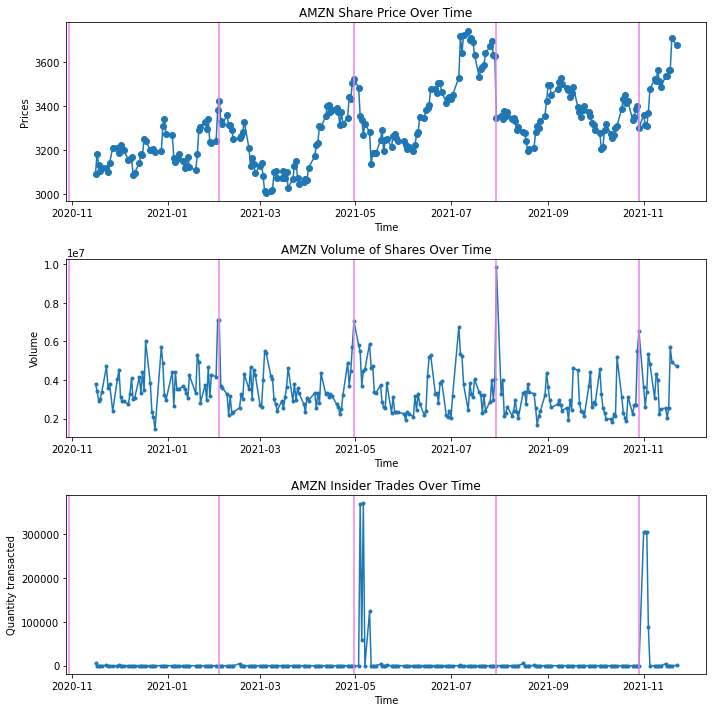

In [212]:
x = list(insider_final_df.Date)

y1 = list(insider_final_df.Price)

y2 = list(insider_final_df.Volume)

y3 = list(insider_final_df.Shares_Sold)




fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

ax1.set_title('AMZN Share Price Over Time')
ax1.plot(x, y1, 'o-')
ax1.set_ylabel('Prices')
ax1.set_xlabel('Time')

ax2.set_title('AMZN Volume of Shares Over Time')
ax2.plot(x, y2, '.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')

ax3.set_title('AMZN Insider Trades Over Time')
ax3.plot(x, y3, '.-')
ax3.set_xlabel('Time')
ax3.set_ylabel('Quantity transacted')

ax1.axvline(relevant_dates[-1], color='violet')
ax1.axvline(relevant_dates[-2], color='violet')
ax1.axvline(relevant_dates[-3], color='violet')
ax1.axvline(relevant_dates[-4], color='violet')
ax1.axvline(relevant_dates[-5], color='violet')

ax2.axvline(relevant_dates[-1], color='violet')
ax2.axvline(relevant_dates[-2], color='violet')
ax2.axvline(relevant_dates[-3], color='violet')
ax2.axvline(relevant_dates[-4], color='violet')
ax2.axvline(relevant_dates[-5], color='violet')

ax3.axvline(relevant_dates[-1], color='violet')
ax3.axvline(relevant_dates[-2], color='violet')
ax3.axvline(relevant_dates[-3], color='violet')
ax3.axvline(relevant_dates[-4], color='violet')
ax3.axvline(relevant_dates[-5], color='violet')


plt.tight_layout()
plt.show()

#### Now, I will scale the process above so that I can view this table for any stock.

In [213]:
def insider_trade_analysis(symbol):
    inside_trade = fmpsdk.insider_trading(apikey, symbol, limit = 750)
    insider_df = pd.DataFrame(columns = ['SharesTransacted', 'Date', 'Volume', 'Open_Price'])

    shares_sold = []
    date = []

    for json in inside_trade:
        if json['transactionType'] == 'S-Sale':
            shares_sold.append(json['securitiesTransacted'])
            date.append(json['transactionDate'])
    insider_df.Date = date
    insider_df.SharesTransacted = shares_sold
    insider_df.SharesTransacted = insider_df.Date.apply(lambda date:
                                np.sum(insider_df.loc[insider_df.Date == date].SharesTransacted))
    insider_df.drop_duplicates(inplace=True)
    insider_df.reset_index(drop=True, inplace=True)
    insider_df.Date = insider_df.Date.apply(lambda date: pd.to_datetime(date))
    current_dates = list(insider_df.Date)
    r = pd.date_range(start=insider_df.Date.min(), end=insider_df.Date.max())
    insider_final_df = pd.DataFrame(columns = ['Date', 'Shares_Sold', 'Volume', 'Price'])
    insider_final_df['Date'] = r
    insider_final_df.Date = insider_final_df.Date.apply(lambda date: pd.to_datetime(date))
    insider_final_df.Shares_Sold = insider_final_df.Date.apply(lambda date:
                                int(insider_df.loc[insider_df.Date == date].SharesTransacted)
                                if date in current_dates
                                else(0))
    
    from_ = insider_final_df.Date.min()
    to_ = insider_final_df.Date.max()
    amzn_stock_data = fmpsdk.historical_price_full(apikey, symbol, from_date = from_,
                                                  to_date = to_)
    
    prices = []
    volumes = []
    dates = []
    vol_price_df = pd.DataFrame(columns = ['price', 'date', 'volume'])
    for json in amzn_stock_data['historical']:
        prices.append(json['open'])
        volumes.append(json['volume'])
        dates.append(json['date']) 
    vol_price_df.price = prices
    vol_price_df.date = dates
    vol_price_df.volume = volumes
    
    vol_price_df.date = vol_price_df.date.apply(lambda date:pd.to_datetime(date))
    stock_dates = list(vol_price_df.date)
    
    insider_final_df.Volume = insider_final_df.Date.apply(lambda date:
                                int(vol_price_df.loc[vol_price_df.date == date].volume)
                                if date in stock_dates else(np.nan))
    insider_final_df.Price = insider_final_df.Date.apply(lambda date:
                                    int(vol_price_df.loc[vol_price_df.date == date].price)
                                    if date in stock_dates else(np.nan))
    
    insider_final_df.dropna(inplace=True)
    insider_final_df.reset_index(drop=True, inplace=True)
    
    earnings_file_dates = fmpsdk.income_statement(apikey, symbol, 'quarter')
    dates = []
    for report in earnings_file_dates:
        dates.append(report['fillingDate'])
    dates = [pd.to_datetime(date) for date in dates]
    relevant_dates = dates[:5]
    
    
    x = list(insider_final_df.Date)

    y1 = list(insider_final_df.Price)

    y2 = list(insider_final_df.Volume)

    y3 = list(insider_final_df.Shares_Sold)




    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

    ax1.set_title(symbol+ ' Share Price Over Time')
    ax1.plot(x, y1, 'o-')
    ax1.set_ylabel('Prices')
    ax1.set_xlabel('Time')

    ax2.set_title(symbol+ ' Volume of Shares Over Time')
    ax2.plot(x, y2, '.-')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volume')

    ax3.set_title(symbol+' Insider Trades Over Time')
    ax3.plot(x, y3, '.-')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Quantity transacted')

    ax1.axvline(relevant_dates[-1], color='violet')
    ax1.axvline(relevant_dates[-2], color='violet')
    ax1.axvline(relevant_dates[-3], color='violet')
    ax1.axvline(relevant_dates[-4], color='violet')
    ax1.axvline(relevant_dates[-5], color='violet')

    ax2.axvline(relevant_dates[-1], color='violet')
    ax2.axvline(relevant_dates[-2], color='violet')
    ax2.axvline(relevant_dates[-3], color='violet')
    ax2.axvline(relevant_dates[-4], color='violet')
    ax2.axvline(relevant_dates[-5], color='violet')

    ax3.axvline(relevant_dates[-1], color='violet')
    ax3.axvline(relevant_dates[-2], color='violet')
    ax3.axvline(relevant_dates[-3], color='violet')
    ax3.axvline(relevant_dates[-4], color='violet')
    ax3.axvline(relevant_dates[-5], color='violet')


    plt.tight_layout()
    plt.show()


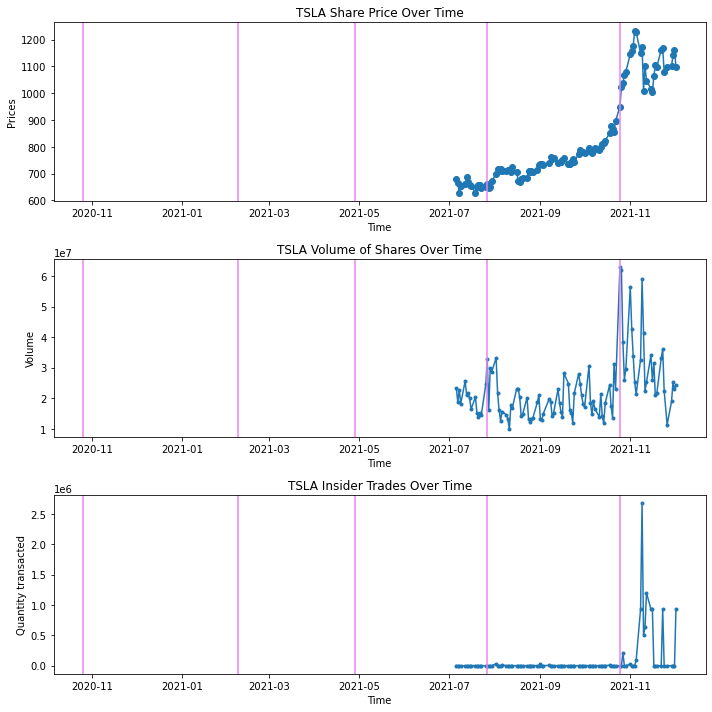

In [214]:
insider_trade_analysis('TSLA')

# Results

## The ARIMA model has higher performance, longer runtimes, and less convenient predictions for tomorrow
- Make 3 models, ARIMA, Daily, and hourly
- Compare time, performance, and usability

In [215]:
amzn_df = build_time_series_df('AMZN')
test_data, train_data = amzn_df[0:int(len(amzn_df)*.7)], \
                            amzn_df[int(len(amzn_df)*.7):]

train = train_data['Close'].values
test = test_data['Close'].values
# Create list of x train valuess
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)
# loop through every data point
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)
MAE_error = mean_absolute_error(test, model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))

Testing Mean Absolute Error is 41.917593695670206


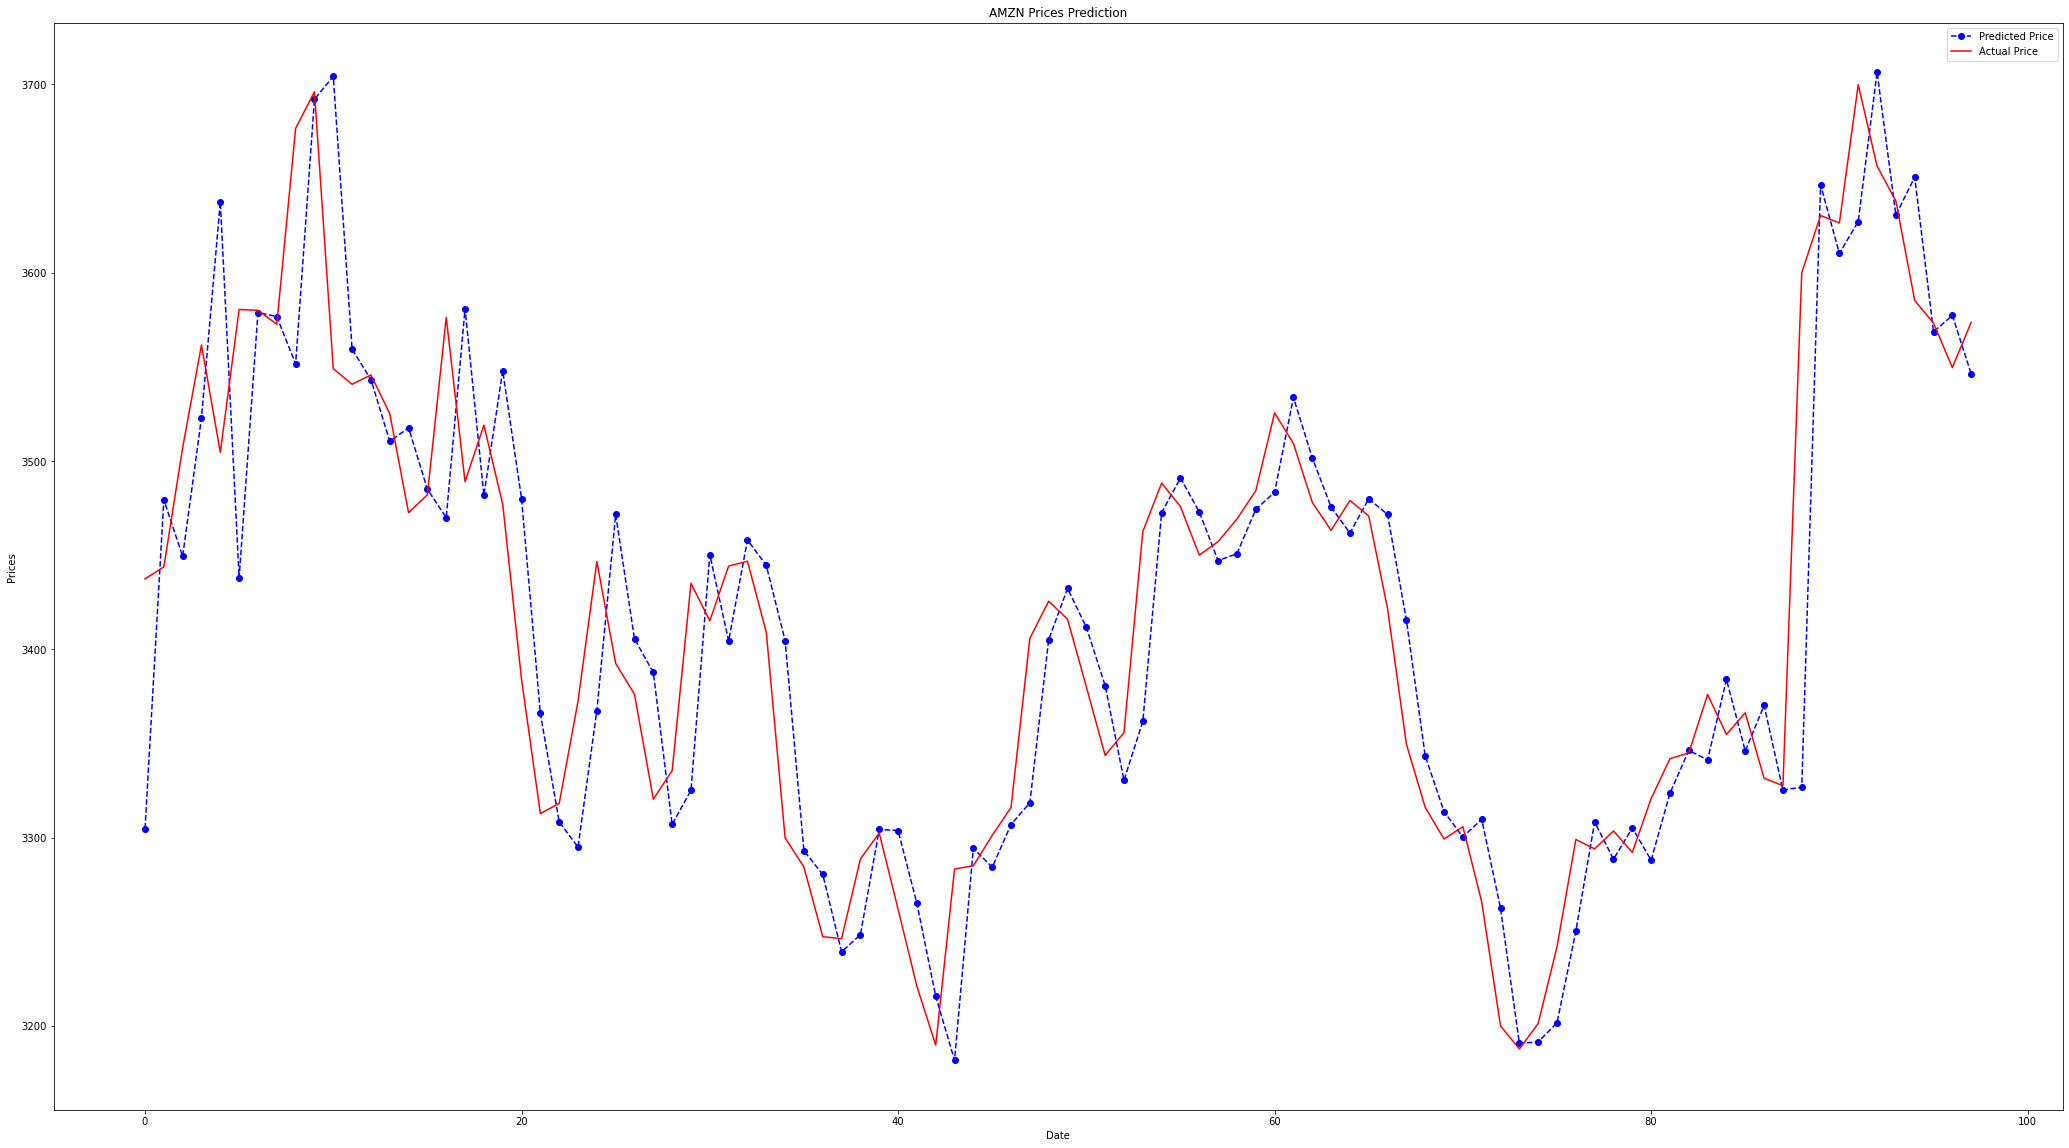

In [216]:
test_range = amzn_df[0:int(len(amzn_df)*.7)].index
plt.plot(test_range, model_predictions, color='blue', marker='o',
        linestyle ='dashed', label='Predicted Price')
plt.plot(test_range, test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
from pylab import rcParams
rcParams['figure.figsize'] = 36, 20
plt.ylabel('Prices')
plt.legend()
plt.show()

#### ARIMA has MAE of 45.5 for Amazon and took 14.6 seconds to run. There is not currently a method to predict tomorrow's close price with this model. I will now look at the daily model

In [217]:
xg_daily_df, xg_daily_model, prediction_daily_df, daily_mae = build_general_model_daily_prediction_df('AMZN')

In [218]:
fig = px.line(xg_daily_df, x='Date', y='value', color='data_category', markers=True,
              title = 'Daily Prediction For AMZN, Next Day Prediction: '+ \
              str(make_tomorrow_pred('AAPL', prediction_daily_df, xg_daily_model)) + '+/- '+str(daily_mae)
             )
fig.show()

#### Daily Stock model took 10.6 seconds and has an MAE of 73.4

In [219]:
xg_hourly_df, xg_hourly_model, prediction_hourly_df, hourly_mae = build_general_model_hourly_prediction_df('AMZN')

In [220]:
fig = px.line(xg_hourly_df, x='Time', y='value', color='data_category', markers=True,
              title = 'Hourly Prediction For AMZN, Next Hour Prediction: '+ \
              str(make_next_hour_pred('AMZN', prediction_hourly_df, xg_hourly_model)) + ' +/- '+str(hourly_mae)
             )
fig.show()

# Final Model Evaluation

- Above the final models are being tested on the holdout test sets and that can be seen through the visualizations. 
- These final models are very valuable to an investing analyst because they show visually and through an error rate (determined by the MAE of the model) how accurate of a prediction the model is making. This will increase confidence when making investments and can be used to detect when to sell investments.

#### Hourly modeling takes 1/2 of a second with an MAE of 44.5

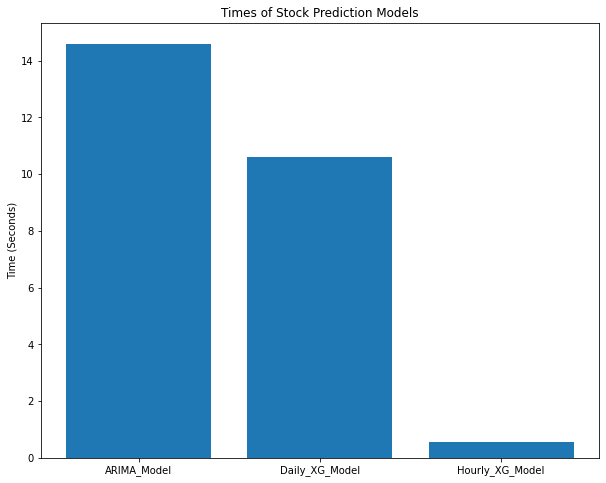

In [221]:

labels_time = ['ARIMA_Model', 'Daily_XG_Model', 'Hourly_XG_Model']
times = [14.6, 10.6, .573]



fig, ax = plt.subplots(figsize = (10,8))
ax.bar(x = labels_time, height = times )
ax.set_title('Times of Stock Prediction Models')
ax.set_ylabel('Time (Seconds)')
plt.show()

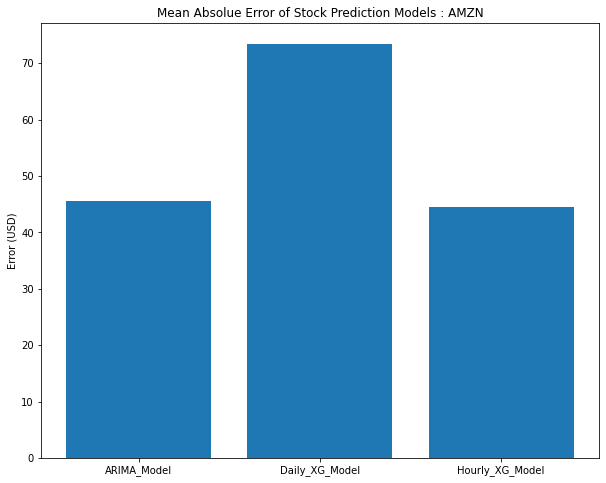

In [222]:
labels_mae = ['ARIMA_Model', 'Daily_XG_Model', 'Hourly_XG_Model']
times = [45.5, 73.45, 44.5]



fig, ax = plt.subplots(figsize = (10,8))
ax.bar(x = labels_time, height = times )
ax.set_title('Mean Absolue Error of Stock Prediction Models : AMZN')
ax.set_ylabel('Error (USD)')
plt.show()

## Adding news sentiment helps the xgboost model performance.

In [223]:
xg_daily_df, xg_daily_model, prediction_daily_df, daily_mae = build_general_model_daily_prediction_df('MSFT')

In [224]:
prediction_daily_df

Close_1day  Close_2day  Close_3day   High_1day   High_2day   High_3day  \
0    330.080000  330.590000  336.630000  339.280000  337.780000  339.030000   
1    330.590000  336.630000  329.680000  337.780000  339.030000  337.930000   
2    336.630000  329.680000  337.910000  339.030000  337.930000  338.160000   
3    329.680000  337.910000  337.680000  337.930000  338.160000  339.450000   
4    337.910000  337.680000  339.830000  338.160000  339.450000  349.665000   
..          ...         ...         ...         ...         ...         ...   
130  249.309998  251.490005  251.720001  251.479996  252.940002  252.750000   
131  251.490005  251.720001  250.779999  252.940002  252.750000  251.160004   
132  251.720001  250.779999  245.169998  252.750000  251.160004  248.330002   
133  250.779999  245.169998  246.479996  251.160004  248.330002  247.949997   
134  245.169998  246.479996  243.119995  248.330002  247.949997  243.229996   

     Cot_1day  Cot_2day  Cot_3day    Vol_1day    Vol_2day    Vol_3day  \
0    -0.01507  -0.01411   0.00505  33339803.0  35737943.0  26461087.0   
1    -0.01411   0.00505  -0.01397  35737943.0  26461087.0  24218928.0   
2     0.00505  -0.01397   0.00485  26461087.0  24218928.0  21662699.0   
3    -0.01397   0.00485   0.00187  24218928.0  21662699.0  30381939.0   
4     0.00485   0.00187  -0.01390  21662699.0  30381939.0  31032206.0   
..        ...       ...       ...         ...         ...         ...   
130  -0.00741   0.00024  -0.00020  24426200.0  17771600.0  17704300.0   
131   0.00024  -0.00020   0.01207  17771600.0  17704300.0  21411500.0   
132  -0.00020   0.01207  -0.00969  17704300.0  21411500.0  21863100.0   
133   0.01207  -0.00969   0.01033  21411500.0  21863100.0  21800700.0   
134  -0.00969   0.01033   0.01592  21863100.0  21800700.0  25739800.0   

          value       Date  News_Sentiment_1day  
0    329.490000 2021-12-02             0.201340  
1    330.080000 2021-12-01             0.078250  
2    330.590000 2021-11-30             0.121057  
3    336.630000 2021-11-29             0.208775  
4    329.680000 2021-11-26             0.223013  
..          ...        ...                  ...  
130  249.679993 2021-05-28            -0.285500  
131  249.309998 2021-05-27             0.428517  
132  251.490005 2021-05-26             0.216464  
133  251.720001 2021-05-25             0.073378  
134  250.779999 2021-05-24             0.150750  

[135 rows x 15 columns]

In [225]:
import seaborn as sns

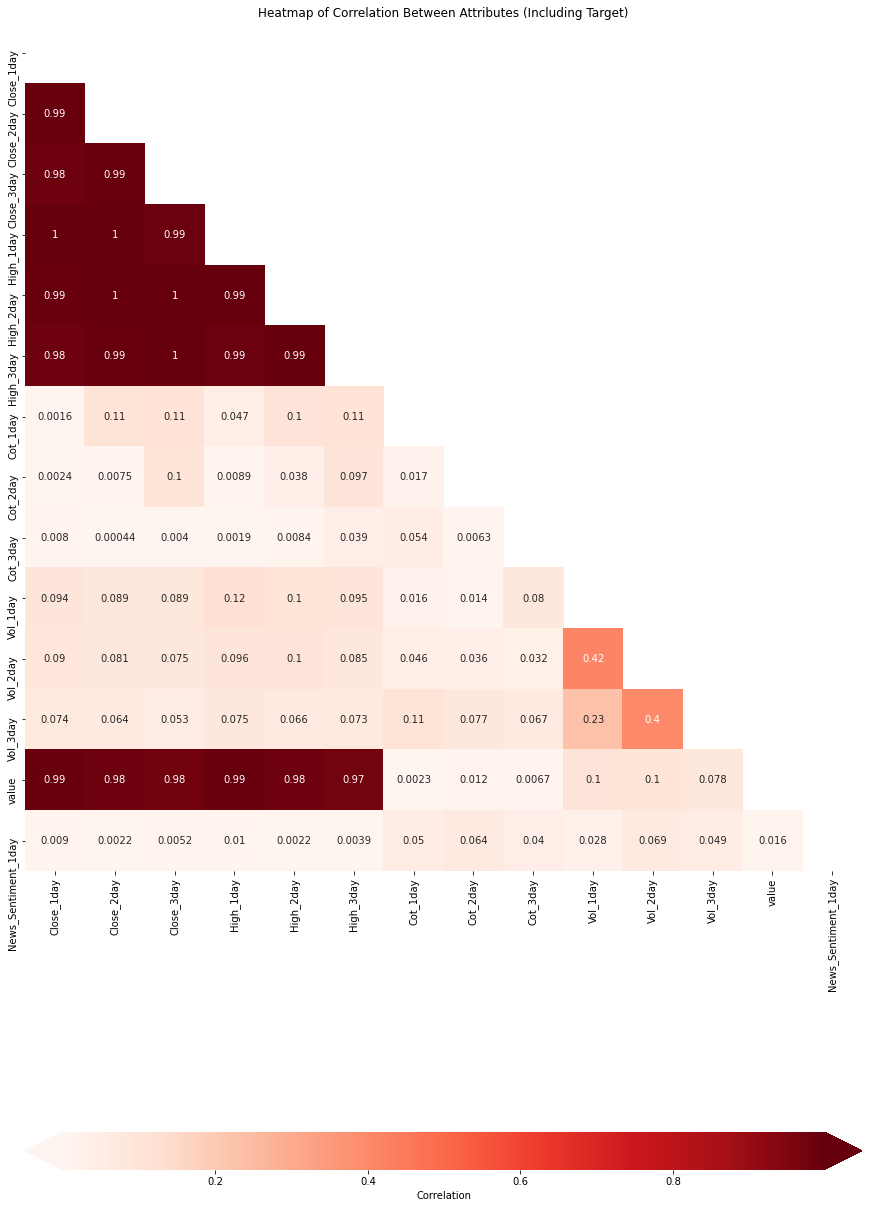

In [226]:

corr = prediction_daily_df.corr().abs()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 24))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    cmap='Reds',
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

#### The news sentiment has a 10% Pearson correlation with the target close price.

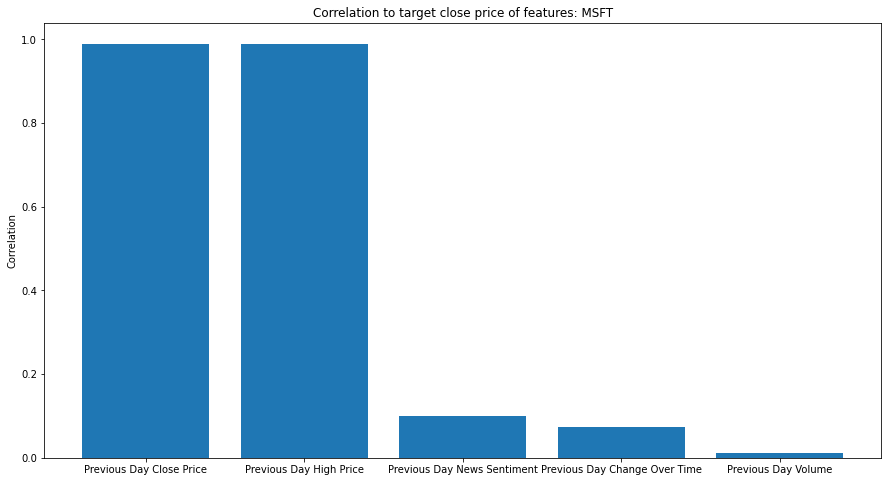

In [227]:
labels = ['Previous Day Close Price', 'Previous Day High Price', 'Previous Day News Sentiment',
         'Previous Day Change Over Time', 'Previous Day Volume']
corrs = [.99, .99 , .1, .074, .012]



fig, ax = plt.subplots(figsize = (15,8))
ax.bar(x = labels, height = corrs )
ax.set_title('Correlation to target close price of features: MSFT')
ax.set_ylabel('Correlation')
plt.show()

# Conclusions

- News sentiment provides valuable information to models.
- Arima models are too slow and ineffective for live dashboard predictions.
- Insider trades can be potential warning signs of a sell off event.

# Further Work

- Provide with more time, I would :
 - Investigate if/how insider training affects model performance
 - Implement analyst ratings to the prediction model
 - Investigate actively raising stocks to determine causers of such movement